### Backtest TF Trading

eda:
- eda indicators
- eda ptc change
- check nan
- check info for continous date for all ticker
- check eligible all time

improve backtest:
- [critical] dieu kien loc mua
- [critical] mua theo tuan
- [high]sau khi tai can bang neu holding ticker co quantity moi > hon holding quantity thi mua them
- [medium] t+2.5
- [medium] don bay (case > 1)


In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# ==============================================================================
# BƯỚC 1: CẤU HÌNH CHIẾN LƯỢC
# ==============================================================================
class StrategyConfig:
    # Universe Filtering
    MIN_PRICE_THRESHOLD = 10000
    MIN_AVG_VOLUME = 100000
    AVG_DOLLAR_VOLUME_WINDOW = 42

    # Entry/Exit Signals
    ATR_WINDOW = 42
    ATR_MULTIPLIER = 10

    # Position Sizing & Risk Management
    VOLATILITY_WINDOW = 42
    TARGET_VOLATILITY = 0.30
    MIN_ASSUMED_HOLDINGS = 30
    MAX_LEVERAGE = 2.0

    # Transaction Costs
    COMMISSION_RATE = 0.0015
    SELL_TAX_RATE = 0.001
    SLIPPAGE_RATE = 0.0005
    
    # Initial Capital
    INITIAL_CAPITAL = 100_000_000


In [2]:
# ==============================================================================
# BƯỚC 2: CHUẨN BỊ VÀ XỬ LÝ DỮ LIỆU
# ==============================================================================
def calculate_indicators(df, config):
    """Tính toán các chỉ báo cần thiết cho một DataFrame cổ phiếu."""
    # Sắp xếp theo thời gian
    df = df.sort_values('time').reset_index(drop=True)

    # Đỉnh mọi thời đại (All-Time High)
    df['ath'] = df['close'].cummax()

    # Tính ATR
    df['prev_close'] = df['close'].shift(1)
    
    # --- XỬ LÝ LỖI ---
    # Thay thế các giá trị NaN hoặc 0 trong prev_close để tránh lỗi chia cho 0
    # Ta có thể thay bằng giá close của chính ngày hôm đó, lợi nhuận sẽ là 0, an toàn
    df['prev_close_safe'] = df['prev_close'].fillna(df['close'])
    df.loc[df['prev_close_safe'] == 0, 'prev_close_safe'] = df['close'] # Nếu prev_close_safe vẫn = 0

    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['prev_close_safe'])
    tr3 = abs(df['low'] - df['prev_close_safe'])
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['atr'] = tr.ewm(span=config.ATR_WINDOW, adjust=False).mean()

    # Tính Volatility (độ biến động hàng năm)
    # Tạo một chuỗi tỷ lệ an toàn để tính log
    ratio = df['close'] / df['prev_close_safe']
    # Nếu tỷ lệ là 0 hoặc âm (do dữ liệu lỗi), thay bằng 1 để log(1)=0
    ratio[ratio <= 0] = 1 
    
    df['daily_return'] = np.log(ratio)
    df['volatility'] = df['daily_return'].rolling(window=config.VOLATILITY_WINDOW).std() * np.sqrt(252)
    
    # Tính thanh khoản
    df['vnd_volume'] = df['volume'] * df['close']
    df['avg_volume'] = df['volume'].rolling(window=config.AVG_DOLLAR_VOLUME_WINDOW).mean()
    df['avg_vnd_volume'] = df['vnd_volume'].rolling(window=config.AVG_DOLLAR_VOLUME_WINDOW).mean()

    # Xóa các cột tạm thời
    return df.drop(columns=['prev_close', 'daily_return', 'vnd_volume', 'prev_close_safe'])

def load_and_prepare_data(data_path, config):
    """Đọc tất cả file CSV, tính chỉ báo và hợp nhất thành một DataFrame lớn."""
    all_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
    all_data = []
    
    print("Bắt đầu đọc và xử lý dữ liệu...")
    for filename in tqdm(all_files, desc="Đang xử lý các mã CP"):
        ticker = filename.split('.')[0]
        filepath = os.path.join(data_path, filename)
        try:
            df = pd.read_csv(filepath)
            # Chuẩn hóa tên cột
            df.columns = df.columns.str.lower()
            df = df[['time', 'open', 'high', 'low', 'close', 'volume']]
            df['time'] = pd.to_datetime(df['time'])
            df['ticker'] = ticker

            price_cols = ['open', 'high', 'low', 'close']
            for col in price_cols:
                df[col] = df[col] * 1000.0

            # Tính toán chỉ báo
            df_with_indicators = calculate_indicators(df, config)
            all_data.append(df_with_indicators)
        except Exception as e:
            print(f"Lỗi khi xử lý file {filename}: {e}")

    # Hợp nhất tất cả dữ liệu
    full_df = pd.concat(all_data, ignore_index=True)
    full_df = full_df.sort_values(by=['time', 'ticker']).reset_index(drop=True)
    
    print(f"\nXử lý dữ liệu hoàn tất. Tổng cộng {full_df['ticker'].nunique()} mã cổ phiếu.")
    print(f"Dữ liệu từ {full_df['time'].min().date()} đến {full_df['time'].max().date()}.")
    
    return full_df.set_index(['time', 'ticker'])


In [3]:
# ==============================================================================
# BƯỚC 3: XÂY DỰNG CLASS QUẢN LÝ DANH MỤC
# ==============================================================================
class Portfolio:
    def __init__(self, config):
        self.config = config
        self.cash = config.INITIAL_CAPITAL
        self.holdings = {}  # { 'FPT': {'quantity': 100, 'entry_price': 120000}, ... }
        self.stop_losses = {} # { 'FPT': 112100, ... }
        self.history = []

    def get_total_value(self, current_prices):
        """Tính tổng giá trị tài sản (NAV)."""
        stock_value = 0
        for ticker, position in self.holdings.items():
            stock_value += position['quantity'] * current_prices.get(ticker, 0)
        return self.cash + stock_value

    def record_nav(self, date, current_prices):
        """Ghi lại giá trị NAV hàng ngày."""
        nav = self.get_total_value(current_prices)
        self.history.append({'date': date, 'nav': nav})

    def execute_buy(self, ticker, price, quantity, sl_data=None):
        """Thực thi lệnh mua và cập nhật stop loss nếu có."""
        cost = price * quantity * (1 + self.config.COMMISSION_RATE + self.config.SLIPPAGE_RATE)
        
        if self.cash < cost:
            print(f"  > [WARNING] Không đủ tiền mặt để mua {quantity} {ticker}.")
            return False # Báo hiệu mua thất bại

        self.cash -= cost
        if ticker in self.holdings:
            # Mua thêm (cho tái cân bằng) - logic này chưa được dùng trong script hiện tại
            total_quantity = self.holdings[ticker]['quantity'] + quantity
            total_cost = self.holdings[ticker]['entry_price'] * self.holdings[ticker]['quantity'] + price * quantity
            self.holdings[ticker]['entry_price'] = total_cost / total_quantity
            self.holdings[ticker]['quantity'] = total_quantity
        else:
            self.holdings[ticker] = {'quantity': quantity, 'entry_price': price}
        
        print(f"  > MUA {quantity} {ticker} @ {price:,.0f} VND")

        # --- PHẦN QUAN TRỌNG: Cập nhật stop loss SAU KHI mua thành công ---
        if sl_data:
            sl_ath = sl_data['ath']
            sl_atr = sl_data['atr']
            sl_close = sl_data['close']
            
            # Thêm một lớp bảo vệ để tránh chia cho 0
            if sl_close > 0 and sl_atr is not None and pd.notna(sl_atr):
                discount_factor = (1 - sl_atr / sl_close) ** self.config.ATR_MULTIPLIER
                self.stop_losses[ticker] = sl_ath * discount_factor
            else:
                # Nếu dữ liệu không hợp lệ, đặt một stop loss an toàn (ví dụ: giá mua - 7%)
                self.stop_losses[ticker] = price * 0.93
                print(f"  > [WARNING] Dữ liệu ATR/Close không hợp lệ cho {ticker}. Đặt SL mặc định.")
        
        return True # Báo hiệu mua thành công

    def execute_sell(self, ticker, price, quantity):
        """Thực thi lệnh bán."""
        if ticker in self.holdings and self.holdings[ticker]['quantity'] >= quantity:
            revenue = price * quantity * (1 - self.config.COMMISSION_RATE - self.config.SELL_TAX_RATE - self.config.SLIPPAGE_RATE)
            self.cash += revenue
            self.holdings[ticker]['quantity'] -= quantity
            if self.holdings[ticker]['quantity'] == 0:
                del self.holdings[ticker]
                del self.stop_losses[ticker]
            print(f"  > BÁN {quantity} {ticker} @ {price:,.0f} VND")
        else:
            print(f"  > [WARNING] Có lỗi khi dev: số lượng bán > số lượng sỡ hữu.")


In [8]:
# ==============================================================================
# BƯỚC 4: LOGIC CHÍNH CỦA BACKTEST (PHIÊN BẢN SỬA LỖI SL)
# ==============================================================================
def run_backtest(data, config):
    portfolio = Portfolio(config)
    all_dates = data.index.get_level_values('time').unique().sort_values()

    # Khởi tạo các danh sách quyết định giao dịch
    buy_list = {}  # { 'ticker': {'quantity': Q, 'sl_data':{...}} }
    sell_list = {} # { 'ticker': quantity }

    print("\nBắt đầu quá trình backtest...")
    for i in tqdm(range(len(all_dates)), desc="Đang mô phỏng giao dịch"):
        today = all_dates[i]
        daily_data_today = data.loc[today]

        # --- 1. (Đầu ngày) THỰC THI GIAO DỊCH ĐÃ QUYẾT ĐỊNH TỪ HÔM TRƯỚC ---
        # Bán trước
        for ticker, quantity in sell_list.items():
            if ticker in daily_data_today.index:
                sell_price = daily_data_today.loc[ticker, 'open']
                portfolio.execute_sell(ticker, sell_price, quantity)
            else:
                print(f'[WARNING] Mã {ticker} (quyết định bán): không tìm thấy trong thông tin giá của ngày hiện tại.')
        
        # Mua sau
        for ticker, order_details in buy_list.items():
            if ticker in daily_data_today.index:
                buy_price = daily_data_today.loc[ticker, 'open']
                quantity = order_details['quantity']
                sl_data = order_details['sl_data']
                portfolio.execute_buy(ticker, buy_price, quantity, sl_data=sl_data)
            else:
                print(f'[WARNING] Mã {ticker} (quyết định mua): không tìm thấy trong thông tin giá của ngày hiện tại.')
        
        # --- 2. (Cuối ngày) KẾT THÚC NGÀY GIAO DỊCH & GHI NHẬN NAV ---
        current_prices = daily_data_today['close'].to_dict()
        portfolio.record_nav(today, current_prices)
        nav_eod = portfolio.get_total_value(current_prices)
        
        if i % 100 == 0:
            print(f"\n--- Ngày: {today.date()} ---")
            print(f"NAV: {nav_eod:,.0f} VND | Tiền mặt: {portfolio.cash:,.0f} VND | CP: {len(portfolio.holdings)}")

        # --- 3. (Cuối ngày) RA QUYẾT ĐỊNH CHO NGÀY MAI ---
        buy_list.clear()
        sell_list.clear()
        
        # A. Quyết định bán (Stop-Loss)
        for ticker, position in list(portfolio.holdings.items()):
            if ticker in daily_data_today.index:
                if daily_data_today.loc[ticker, 'close'] < portfolio.stop_losses['ticker']:
                    sell_list[ticker] = position['quantity']
            else:
                print(f'[WARNING] Mã {ticker} (holding): không tìm thấy trong thông tin giá của ngày hiện tại.')

        # B. Quyết định mua mới
        # 1. Lọc vũ trụ & tìm tín hiệu
        eligible = daily_data_today[
            (daily_data_today['close'] > config.MIN_PRICE_THRESHOLD) &
            (daily_data_today['avg_volume'] > config.MIN_AVG_VOLUME) &
            (daily_data_today['volatility'] > 0)
        ]

        new_signals = eligible[
            (eligible['close'] >= eligible['ath']) &
            (~eligible.index.isin(portfolio.holdings.keys()))
        ]

        # 2. Tính toán trọng số (sử dụng NAV cuối ngày hôm nay)
        current_holdings = [t for t in portfolio.holdings.keys() if t not in sell_list]
        target_holdings = current_holdings + list(new_signals.index)
        
        if not target_holdings:
            continue
            
        n_holdings = len(target_holdings)
        weights = {}
        total_weight = 0
        for ticker in target_holdings:
            if ticker in daily_data_today.index:
                vol = daily_data_today.loc[ticker, 'volatility']
                if pd.notna(vol) and vol > 0:
                    weight = (config.TARGET_VOLATILITY / vol) * (1 / max(config.MIN_ASSUMED_HOLDINGS, n_holdings))
                    weights[ticker] = weight
                    total_weight += weight
                else:
                    print(f'[INFO] Mã {ticker} có volatility trong n ngày không hợp lệ.')
            else:
                if ticker not in new_signals.index:
                    print(f'[WARNING] Mã {ticker} (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.')

        if total_weight > config.MAX_LEVERAGE:
            weights = {t: w * (config.MAX_LEVERAGE / total_weight) for t, w in weights.items()}

        # 3. Tạo lệnh mua và gói kèm dữ liệu SL
        for ticker in new_signals.index:
            if ticker in weights:
                estimated_price = daily_data_today.loc[ticker, 'close']
                target_value = weights[ticker] * nav_eod
                quantity = int(target_value / estimated_price)
                
                if quantity > 0:
                    # Gói dữ liệu cần thiết để tính SL vào lệnh mua
                    sl_data_package = {
                        'ath': daily_data_today.loc[ticker, 'ath'],
                        'atr': daily_data_today.loc[ticker, 'atr'],
                        'close': daily_data_today.loc[ticker, 'close']
                    }
                    buy_list[ticker] = {
                        'quantity': quantity,
                        'sl_data': sl_data_package
                    }
        
        # C. Cập nhật trailing stop-loss cho các vị thế hiện tại
        for ticker in current_holdings:
            if ticker in daily_data_today.index:
                data_row = daily_data_today.loc[ticker]
                new_sl_candidate = data_row['ath'] * ((1 - data_row['atr'] / data_row['close']) ** config.ATR_MULTIPLIER)
                
                if new_sl_candidate > portfolio.stop_losses.get(ticker, 0):
                    portfolio.stop_losses[ticker] = new_sl_candidate

    return pd.DataFrame(portfolio.history).set_index('date')


In [ ]:
# ==============================================================================
# BƯỚC 5: CHẠY CHƯƠNG TRÌNH
# ==============================================================================
DATA_PATH = '/mnt/c/Users/HOME/Downloads/TF-algo-trading/vci_stock_history'
config = StrategyConfig()

# Chạy một lần để chuẩn bị dữ liệu
full_data = load_and_prepare_data(DATA_PATH, config)
full_data_backup = full_data.copy()

Bắt đầu đọc và xử lý dữ liệu...


Đang xử lý các mã CP:   0%|                                                                                                                     | 0/1686 [00:00<?, ?it/s]

Đang xử lý các mã CP: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1686/1686 [01:18<00:00, 21.51it/s]



Xử lý dữ liệu hoàn tất. Tổng cộng 1686 mã cổ phiếu.
Dữ liệu từ 2000-07-28 đến 2025-09-12.


In [ ]:
# Chạy backtest
results = run_backtest(full_data, config)


Bắt đầu quá trình backtest...


Đang mô phỏng giao dịch:   1%|▊                                                                                                       | 47/6124 [00:00<00:13, 466.00it/s]


--- Ngày: 2000-07-28 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:   2%|██▏                                                                                                    | 130/6124 [00:00<00:25, 230.59it/s]


--- Ngày: 2001-03-30 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:   4%|████▎                                                                                                  | 258/6124 [00:00<00:18, 311.51it/s]


--- Ngày: 2001-11-23 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0

--- Ngày: 2002-05-30 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:   8%|███████▉                                                                                               | 475/6124 [00:01<00:12, 450.21it/s]


--- Ngày: 2002-10-18 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0

--- Ngày: 2003-03-20 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:  11%|███████████▎                                                                                           | 673/6124 [00:01<00:12, 435.80it/s]


--- Ngày: 2003-08-12 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0

--- Ngày: 2004-01-05 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:  14%|██████████████▋                                                                                        | 874/6124 [00:02<00:15, 342.63it/s]


--- Ngày: 2004-06-03 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0

--- Ngày: 2004-10-25 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:  18%|██████████████████▏                                                                                   | 1093/6124 [00:03<00:13, 382.74it/s]


--- Ngày: 2005-03-17 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0

--- Ngày: 2005-08-03 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:  20%|████████████████████▍                                                                                 | 1230/6124 [00:03<00:13, 374.25it/s]


--- Ngày: 2005-12-19 ---
NAV: 100,000,000 VND | Tiền mặt: 100,000,000 VND | CP: 0


Đang mô phỏng giao dịch:  21%|█████████████████████▏                                                                                | 1270/6124 [00:03<00:13, 349.15it/s]

  > MUA 85 BBC @ 26,080 VND
  > MUA 141 TYA @ 16,080 VND


Đang mô phỏng giao dịch:  22%|██████████████████████▎                                                                               | 1337/6124 [00:04<00:20, 238.40it/s]


--- Ngày: 2006-05-17 ---
NAV: 100,805,392 VND | Tiền mặt: 95,506,952 VND | CP: 2
  > BÁN 85 BBC @ 25,870 VND
  > BÁN 141 TYA @ 16,050 VND


Đang mô phỏng giao dịch:  24%|████████████████████████▎                                                                             | 1459/6124 [00:04<00:14, 318.67it/s]

  > MUA 189 GMD @ 16,510 VND

--- Ngày: 2006-10-05 ---
NAV: 100,038,155 VND | Tiền mặt: 96,828,935 VND | CP: 1
  > MUA 170 SAM @ 16,170 VND
  > MUA 233 PPC @ 10,970 VND


Đang mô phỏng giao dịch:  24%|████████████████████████▉                                                                             | 1495/6124 [00:04<00:18, 244.28it/s]

  > MUA 204 STB @ 13,450 VND
  > MUA 187 CII @ 10,250 VND
  > MUA 193 BMP @ 10,600 VND
[WARNING] Mã PPC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 131 ITA @ 17,990 VND
[WARNING] Mã PPC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã PPC (holding): không tìm t

Đang mô phỏng giao dịch:  25%|█████████████████████████▍                                                                            | 1525/6124 [00:04<00:24, 185.90it/s]

[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã ICF (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 58 BBC @ 34,950 VND
[WARNING] Mã ICF (holding): không tìm th

Đang mô phỏng giao dịch:  26%|██████████████████████████                                                                            | 1568/6124 [00:05<00:37, 121.20it/s]

[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
  > MUA 67 SJS @ 27,580 VND
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
  > BÁN 170 SAM @ 23,370 VND
  > BÁN 46 ICF @ 26,420 VND
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n ngày không hợp lệ.
[INFO] Mã PPC có volatility trong n

Đang mô phỏng giao dịch:  26%|██████████████████████████▋                                                                           | 1601/6124 [00:05<00:40, 112.10it/s]

  > BÁN 233 PPC @ 15,120 VND

--- Ngày: 2007-07-27 ---
NAV: 104,888,840 VND | Tiền mặt: 94,671,780 VND | CP: 5
  > BÁN 67 SJS @ 29,380 VND


Đang mô phỏng giao dịch:  27%|███████████████████████████▊                                                                          | 1668/6124 [00:06<00:25, 176.76it/s]

  > BÁN 66 BCC @ 19,520 VND
  > MUA 202 PPC @ 16,330 VND
  > MUA 144 VSH @ 14,490 VND
  > MUA 66 VNE @ 29,840 VND
[WARNING] Mã SSI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SSI (holding): không tìm thấ

Đang mô phỏng giao dịch:  28%|████████████████████████████▋                                                                         | 1725/6124 [00:06<00:31, 141.25it/s]

  > BÁN 144 VSH @ 10,810 VND

--- Ngày: 2007-12-17 ---
NAV: 104,251,262 VND | Tiền mặt: 93,646,002 VND | CP: 4
  > BÁN 66 VNE @ 23,790 VND
  > BÁN 176 SSI @ 12,660 VND
  > BÁN 202 PPC @ 12,700 VND


Đang mô phỏng giao dịch:  28%|████████████████████████████▉                                                                         | 1741/6124 [00:06<00:32, 133.06it/s]

  > BÁN 131 ITA @ 25,340 VND


Đang mô phỏng giao dịch:  30%|██████████████████████████████▎                                                                       | 1817/6124 [00:07<00:35, 123.02it/s]


--- Ngày: 2008-05-22 ---
NAV: 103,300,193 VND | Tiền mặt: 103,300,193 VND | CP: 0


Đang mô phỏng giao dịch:  32%|████████████████████████████████▏                                                                     | 1935/6124 [00:08<00:21, 197.73it/s]


--- Ngày: 2008-10-13 ---
NAV: 103,300,193 VND | Tiền mặt: 103,300,193 VND | CP: 0


Đang mô phỏng giao dịch:  34%|██████████████████████████████████▏                                                                   | 2052/6124 [00:08<00:13, 311.94it/s]


--- Ngày: 2009-03-10 ---
NAV: 103,300,193 VND | Tiền mặt: 103,300,193 VND | CP: 0
  > MUA 109 HAG @ 20,910 VND
  > MUA 177 LCG @ 10,280 VND
  > MUA 205 NBB @ 10,850 VND
  > MUA 143 PVG @ 10,840 VND
  > MUA 130 VST @ 13,560 VND
  > MUA 106 VCG @ 13,180 VND
  > MUA 81 BLF @ 17,820 VND
  > MUA 55 STL @ 24,800 VND
  > MUA 83 HLA @ 22,070 VND
  > BÁN 177 LCG @ 9,540 VND
  > BÁN 81 BLF @ 11,360 VND
  > BÁN 83 HLA @ 16,080 VND
  > BÁN 143 PVG @ 7,390 VND
  > BÁN 106 VCG @ 8,460 VND


Đang mô phỏng giao dịch:  35%|███████████████████████████████████▎                                                                  | 2118/6124 [00:08<00:18, 216.95it/s]


--- Ngày: 2009-07-31 ---
NAV: 101,159,767 VND | Tiền mặt: 93,475,837 VND | CP: 4
  > MUA 69 HLA @ 24,730 VND
  > MUA 164 LSS @ 12,190 VND
  > MUA 137 PVG @ 13,160 VND


Đang mô phỏng giao dịch:  35%|███████████████████████████████████▊                                                                  | 2149/6124 [00:08<00:16, 236.63it/s]

  > MUA 119 VCG @ 14,520 VND
  > MUA 106 CNT @ 18,350 VND
  > MUA 105 UNI @ 17,630 VND
  > MUA 171 VGS @ 10,660 VND
  > MUA 119 PVA @ 15,620 VND
  > MUA 133 SSM @ 12,430 VND
  > MUA 49 KSH @ 44,540 VND
  > MUA 295 HOM @ 10,590 VND
  > MUA 107 SDP @ 16,920 VND
  > MUA 114 ICG @ 18,160 VND
  > MUA 137 SD4 @ 14,090 VND
  > MUA 114 VC1 @ 15,180 VND
  > MUA 257 NBP @ 10,900 VND
  > MUA 101 PVX @ 24,070 VND
  > MUA 82 BKC @ 20,590 VND
  > MUA 164 CII @ 15,380 VND
  > BÁN 107 SDP @ 18,670 VND
  > BÁN 257 NBP @ 6,430 VND
  > BÁN 49 KSH @ 60,110 VND
  > BÁN 164 LSS @ 12,800 VND
  > BÁN 106 CNT @ 13,170 VND


Đang mô phỏng giao dịch:  36%|████████████████████████████████████▋                                                                 | 2202/6124 [00:09<00:17, 219.27it/s]

  > MUA 222 VIC @ 10,060 VND
  > BÁN 69 HLA @ 23,970 VND
  > BÁN 119 VCG @ 14,970 VND
  > BÁN 119 PVA @ 11,610 VND
  > BÁN 133 SSM @ 7,490 VND
  > BÁN 114 ICG @ 11,410 VND
  > BÁN 137 SD4 @ 9,770 VND
  > BÁN 114 VC1 @ 10,960 VND
  > BÁN 55 STL @ 32,950 VND
  > BÁN 105 UNI @ 12,650 VND
  > BÁN 101 PVX @ 17,050 VND
  > BÁN 109 HAG @ 29,090 VND
  > BÁN 130 VST @ 13,420 VND
  > BÁN 171 VGS @ 8,970 VND
  > BÁN 137 PVG @ 10,200 VND
  > BÁN 82 BKC @ 9,930 VND
  > BÁN 295 HOM @ 6,350 VND
  > BÁN 164 CII @ 10,740 VND

--- Ngày: 2009-12-21 ---
NAV: 95,616,932 VND | Tiền mặt: 89,342,062 VND | CP: 2
  > MUA 67 PVA @ 22,220 VND
  > MUA 69 ITC @ 23,580 VND
  > MUA 90 SSM @ 13,530 VND


Đang mô phỏng giao dịch:  37%|██████████████████████████████████████                                                                | 2287/6124 [00:09<00:17, 225.55it/s]

  > MUA 136 SHN @ 10,940 VND
  > MUA 69 HAG @ 41,130 VND
  > MUA 150 HUT @ 10,190 VND
  > MUA 77 V15 @ 20,120 VND
  > MUA 128 TIE @ 16,270 VND
  > MUA 14 CNT @ 20,670 VND
  > MUA 61 MCG @ 33,100 VND
  > MUA 43 DCS @ 35,300 VND
  > MUA 135 MAC @ 10,960 VND
  > MUA 53 SDU @ 53,720 VND
  > MUA 150 TKC @ 11,200 VND
  > MUA 114 L44 @ 13,200 VND
  > MUA 233 MTG @ 11,280 VND
  > MUA 68 PDC @ 24,100 VND
  > MUA 169 PGT @ 10,880 VND
  > MUA 114 VC9 @ 15,370 VND
  > MUA 82 VE1 @ 21,800 VND
  > MUA 75 PVX @ 28,660 VND


Đang mô phỏng giao dịch:  38%|██████████████████████████████████████▊                                                               | 2334/6124 [00:09<00:18, 201.58it/s]

  > BÁN 43 DCS @ 21,030 VND
  > BÁN 68 PDC @ 15,700 VND
  > BÁN 67 PVA @ 49,040 VND
  > BÁN 90 SSM @ 14,000 VND
  > BÁN 135 MAC @ 6,860 VND

--- Ngày: 2010-05-21 ---
NAV: 93,182,036 VND | Tiền mặt: 59,736,946 VND | CP: 18
  > BÁN 136 SHN @ 16,170 VND
  > BÁN 61 MCG @ 24,960 VND
  > BÁN 150 TKC @ 9,110 VND
  > MUA 74 MSN @ 25,990 VND
  > MUA 159 VE9 @ 10,850 VND
  > MUA 62 VES @ 25,900 VND
  > MUA 125 VNG @ 16,740 VND
  > MUA 49 GGG @ 25,160 VND
  > MUA 31 S96 @ 41,100 VND
  > MUA 86 UNI @ 20,750 VND
  > MUA 77 SRB @ 16,600 VND
  > MUA 98 CTI @ 17,680 VND
  > BÁN 69 ITC @ 18,050 VND
  > MUA 99 LIG @ 13,050 VND
  > MUA 78 DXV @ 21,760 VND
  > MUA 105 FDC @ 19,210 VND


Đang mô phỏng giao dịch:  38%|███████████████████████████████████████▏                                                              | 2355/6124 [00:09<00:19, 194.15it/s]

  > MUA 51 SHN @ 27,750 VND
  > MUA 71 OGC @ 30,690 VND
  > MUA 107 CTC @ 15,580 VND
  > MUA 29 MKV @ 40,980 VND
  > BÁN 114 VC9 @ 10,800 VND
  > BÁN 86 UNI @ 17,510 VND
  > BÁN 128 TIE @ 12,240 VND
  > BÁN 75 PVX @ 21,090 VND
  > BÁN 205 NBB @ 27,450 VND
  > BÁN 233 MTG @ 11,170 VND
  > BÁN 105 FDC @ 18,030 VND
  > BÁN 14 CNT @ 15,580 VND
  > BÁN 77 SRB @ 16,900 VND
  > BÁN 69 HAG @ 34,060 VND
  > BÁN 159 VE9 @ 12,320 VND
  > BÁN 107 CTC @ 10,340 VND
  > BÁN 62 VES @ 20,700 VND
  > BÁN 78 DXV @ 15,970 VND
  > BÁN 53 SDU @ 45,880 VND
  > BÁN 82 VE1 @ 18,000 VND
  > BÁN 49 GGG @ 13,860 VND
  > BÁN 98 CTI @ 15,240 VND
  > BÁN 31 S96 @ 25,040 VND
  > BÁN 51 SHN @ 22,310 VND
  > BÁN 71 OGC @ 23,750 VND


Đang mô phỏng giao dịch:  39%|███████████████████████████████████████▉                                                              | 2395/6124 [00:10<00:24, 149.22it/s]

  > BÁN 222 VIC @ 8,600 VND
  > MUA 65 AAA @ 19,220 VND
  > MUA 116 DTL @ 17,570 VND
  > MUA 73 BVH @ 35,940 VND
  > BÁN 65 AAA @ 11,550 VND
  > BÁN 114 L44 @ 9,400 VND

--- Ngày: 2010-10-12 ---
NAV: 88,569,609 VND | Tiền mặt: 72,739,429 VND | CP: 9


Đang mô phỏng giao dịch:  40%|████████████████████████████████████████▌                                                             | 2436/6124 [00:10<00:21, 170.10it/s]

  > BÁN 169 PGT @ 7,130 VND
  > BÁN 150 HUT @ 9,420 VND
  > BÁN 77 V15 @ 16,260 VND
  > BÁN 99 LIG @ 6,800 VND
  > MUA 204 VIC @ 11,460 VND
  > BÁN 29 MKV @ 39,150 VND
  > MUA 120 DLG @ 19,730 VND


Đang mô phỏng giao dịch:  41%|█████████████████████████████████████████▎                                                            | 2481/6124 [00:10<00:18, 192.75it/s]

  > MUA 104 HQC @ 18,420 VND
  > MUA 192 VNF @ 10,120 VND
  > BÁN 73 BVH @ 52,480 VND

--- Ngày: 2011-03-10 ---
NAV: 91,076,062 VND | Tiền mặt: 73,639,192 VND | CP: 7


Đang mô phỏng giao dịch:  42%|██████████████████████████████████████████▉                                                           | 2580/6124 [00:10<00:12, 274.04it/s]

  > MUA 342 VNM @ 10,450 VND
  > BÁN 192 VNF @ 5,740 VND
  > BÁN 104 HQC @ 16,920 VND
  > BÁN 74 MSN @ 45,810 VND
  > BÁN 116 DTL @ 15,180 VND
  > BÁN 204 VIC @ 15,440 VND
  > BÁN 342 VNM @ 8,990 VND
  > MUA 76 VIC @ 21,520 VND
  > MUA 182 VNM @ 11,660 VND
  > BÁN 120 DLG @ 15,920 VND

--- Ngày: 2011-08-03 ---
NAV: 87,974,597 VND | Tiền mặt: 82,391,867 VND | CP: 3
  > BÁN 76 VIC @ 16,680 VND
  > BÁN 125 VNG @ 14,890 VND


Đang mô phỏng giao dịch:  45%|██████████████████████████████████████████████                                                        | 2765/6124 [00:11<00:10, 312.12it/s]


--- Ngày: 2011-12-22 ---
NAV: 88,032,110 VND | Tiền mặt: 85,511,410 VND | CP: 1
  > MUA 142 FLC @ 10,590 VND
  > BÁN 182 VNM @ 11,930 VND
  > MUA 295 EIB @ 10,260 VND
  > MUA 121 JVC @ 15,100 VND
  > BÁN 142 FLC @ 15,490 VND
  > MUA 174 CTG @ 10,970 VND


Đang mô phỏng giao dịch:  47%|███████████████████████████████████████████████▊                                                      | 2874/6124 [00:11<00:09, 340.49it/s]


--- Ngày: 2012-05-23 ---
NAV: 88,158,635 VND | Tiền mặt: 81,586,245 VND | CP: 3
  > BÁN 121 JVC @ 13,900 VND
  > BÁN 295 EIB @ 9,880 VND
  > BÁN 174 CTG @ 8,970 VND


Đang mô phỏng giao dịch:  48%|█████████████████████████████████████████████████                                                     | 2944/6124 [00:12<00:09, 319.78it/s]

  > MUA 134 VNM @ 17,990 VND

--- Ngày: 2012-10-11 ---
NAV: 87,827,432 VND | Tiền mặt: 85,309,572 VND | CP: 1
  > MUA 82 DHM @ 19,880 VND


Đang mô phỏng giao dịch:  49%|█████████████████████████████████████████████████▌                                                    | 2977/6124 [00:12<00:10, 291.02it/s]

  > MUA 220 SII @ 11,880 VND
  > MUA 273 GAS @ 18,290 VND
  > BÁN 82 DHM @ 14,700 VND
  > MUA 198 CTG @ 11,210 VND

--- Ngày: 2013-03-11 ---
NAV: 88,598,522 VND | Tiền mặt: 75,031,932 VND | CP: 4


Đang mô phỏng giao dịch:  50%|███████████████████████████████████████████████████▏                                                  | 3072/6124 [00:12<00:10, 295.25it/s]

  > MUA 49 HAR @ 29,100 VND
  > BÁN 198 CTG @ 8,680 VND
  > BÁN 49 HAR @ 21,400 VND
  > MUA 363 LAS @ 10,160 VND
  > MUA 203 DRC @ 10,460 VND
  > MUA 152 HVG @ 14,350 VND


Đang mô phỏng giao dịch:  51%|███████████████████████████████████████████████████▋                                                  | 3103/6124 [00:12<00:10, 295.38it/s]


--- Ngày: 2013-08-02 ---
NAV: 92,457,884 VND | Tiền mặt: 68,353,474 VND | CP: 6


Đang mô phỏng giao dịch:  52%|████████████████████████████████████████████████████▌                                                 | 3159/6124 [00:13<00:13, 217.19it/s]

  > BÁN 152 HVG @ 10,550 VND
  > BÁN 363 LAS @ 10,830 VND


Đang mô phỏng giao dịch:  53%|██████████████████████████████████████████████████████                                                | 3243/6124 [00:13<00:11, 252.57it/s]


--- Ngày: 2013-12-23 ---
NAV: 92,349,389 VND | Tiền mặt: 73,871,759 VND | CP: 4
  > MUA 227 PXS @ 10,050 VND
  > MUA 345 PGS @ 10,550 VND
  > MUA 257 FCN @ 10,550 VND
  > MUA 235 C32 @ 10,630 VND
  > MUA 322 PGD @ 10,220 VND
  > MUA 185 GTT @ 15,600 VND
  > MUA 350 HVG @ 14,650 VND
  > MUA 126 TIE @ 17,760 VND
  > MUA 162 CII @ 15,510 VND
  > BÁN 185 GTT @ 11,200 VND


Đang mô phỏng giao dịch:  53%|██████████████████████████████████████████████████████▌                                               | 3274/6124 [00:13<00:10, 264.86it/s]

  > BÁN 345 PGS @ 9,760 VND
  > BÁN 126 TIE @ 13,060 VND
  > BÁN 134 VNM @ 31,080 VND
  > BÁN 227 PXS @ 10,840 VND
  > BÁN 350 HVG @ 13,050 VND
  > BÁN 162 CII @ 11,750 VND
  > BÁN 220 SII @ 17,000 VND


Đang mô phỏng giao dịch:  54%|███████████████████████████████████████████████████████▍                                              | 3325/6124 [00:13<00:14, 189.63it/s]


--- Ngày: 2014-05-28 ---
NAV: 94,228,235 VND | Tiền mặt: 70,481,565 VND | CP: 5
  > MUA 205 CSM @ 19,210 VND


Đang mô phỏng giao dịch:  55%|████████████████████████████████████████████████████████▏                                             | 3374/6124 [00:14<00:13, 201.78it/s]

  > MUA 81 PVD @ 46,530 VND
  > MUA 235 PLC @ 10,220 VND
  > MUA 145 PXS @ 17,760 VND
  > MUA 158 VIC @ 24,690 VND
  > MUA 47 PVB @ 36,580 VND
  > MUA 190 PGS @ 13,000 VND
  > MUA 209 HVG @ 16,970 VND
  > MUA 138 PAN @ 21,170 VND
  > MUA 206 ASA @ 18,550 VND
  > MUA 167 FIT @ 11,210 VND
  > BÁN 206 ASA @ 18,260 VND
  > MUA 80 HAI @ 18,180 VND


Đang mô phỏng giao dịch:  56%|████████████████████████████████████████████████████████▉                                             | 3422/6124 [00:14<00:13, 203.40it/s]

  > MUA 215 VHC @ 12,150 VND

--- Ngày: 2014-10-17 ---
NAV: 95,774,236 VND | Tiền mặt: 37,155,466 VND | CP: 17
  > MUA 190 IVS @ 10,200 VND
  > BÁN 145 PXS @ 20,290 VND
  > MUA 115 SRC @ 15,410 VND
  > MUA 122 ITQ @ 14,400 VND
  > BÁN 273 GAS @ 46,270 VND
  > BÁN 81 PVD @ 43,170 VND
  > MUA 99 APC @ 20,250 VND
  > BÁN 80 HAI @ 14,750 VND


Đang mô phỏng giao dịch:  57%|█████████████████████████████████████████████████████████▊                                            | 3468/6124 [00:14<00:12, 213.21it/s]

  > BÁN 47 PVB @ 30,920 VND
  > BÁN 257 FCN @ 12,270 VND
  > BÁN 158 VIC @ 20,400 VND
  > BÁN 190 PGS @ 10,200 VND
  > BÁN 122 ITQ @ 23,920 VND
  > BÁN 322 PGD @ 9,870 VND
  > BÁN 205 CSM @ 16,170 VND
  > BÁN 209 HVG @ 15,390 VND
  > BÁN 203 DRC @ 14,580 VND
  > BÁN 115 SRC @ 12,710 VND
  > BÁN 167 FIT @ 10,310 VND
  > MUA 237 VCB @ 10,100 VND
  > MUA 108 KSQ @ 11,300 VND
  > MUA 118 JVC @ 20,300 VND
  > MUA 230 MWG @ 10,890 VND
  > BÁN 108 KSQ @ 7,100 VND


Đang mô phỏng giao dịch:  57%|██████████████████████████████████████████████████████████▌                                           | 3517/6124 [00:14<00:11, 220.69it/s]

  > MUA 184 CTG @ 11,470 VND
  > BÁN 138 PAN @ 17,790 VND

--- Ngày: 2015-03-18 ---
NAV: 93,571,370 VND | Tiền mặt: 70,877,940 VND | CP: 9
  > BÁN 230 MWG @ 9,820 VND
  > BÁN 99 APC @ 15,720 VND
  > BÁN 215 VHC @ 10,540 VND


Đang mô phỏng giao dịch:  58%|███████████████████████████████████████████████████████████▍                                          | 3572/6124 [00:14<00:10, 236.95it/s]

  > MUA 171 HHS @ 11,460 VND
  > MUA 172 DAG @ 10,350 VND
  > MUA 268 BID @ 10,140 VND
  > BÁN 118 JVC @ 17,300 VND
  > MUA 121 CDO @ 16,260 VND
  > MUA 105 AMD @ 19,440 VND
  > BÁN 172 DAG @ 8,730 VND
  > MUA 47 KVC @ 25,770 VND
  > BÁN 171 HHS @ 8,860 VND
  > MUA 135 DPS @ 17,900 VND
  > MUA 116 CII @ 17,280 VND
  > MUA 197 BIC @ 10,660 VND
  > BÁN 135 DPS @ 12,780 VND
  > BÁN 105 AMD @ 14,170 VND
  > MUA 137 VNM @ 37,320 VND
  > MUA 189 PGD @ 12,210 VND


Đang mô phỏng giao dịch:  59%|████████████████████████████████████████████████████████████▍                                         | 3626/6124 [00:15<00:10, 242.34it/s]

  > BÁN 47 KVC @ 20,520 VND

--- Ngày: 2015-08-11 ---
NAV: 93,133,152 VND | Tiền mặt: 60,478,582 VND | CP: 11
  > MUA 101 FID @ 12,070 VND
  > BÁN 237 VCB @ 11,490 VND
  > BÁN 101 FID @ 10,170 VND
  > MUA 94 BMP @ 27,370 VND
  > MUA 224 NT2 @ 9,980 VND
  > MUA 218 BCG @ 10,550 VND


Đang mô phỏng giao dịch:  60%|█████████████████████████████████████████████████████████████▎                                        | 3679/6124 [00:15<00:10, 225.22it/s]

  > MUA 287 PDB @ 10,130 VND
  > MUA 122 HKB @ 10,170 VND
  > MUA 156 PTI @ 13,460 VND
  > BÁN 116 CII @ 14,600 VND
  > MUA 200 CAV @ 14,230 VND
  > MUA 349 KSB @ 10,030 VND
  > MUA 165 VCS @ 10,580 VND
  > BÁN 268 BID @ 10,870 VND
  > BÁN 197 BIC @ 7,990 VND
  > MUA 81 DPS @ 17,900 VND
  > BÁN 184 CTG @ 11,360 VND


Đang mô phỏng giao dịch:  61%|██████████████████████████████████████████████████████████████                                        | 3726/6124 [00:15<00:11, 211.76it/s]

  > MUA 268 VSC @ 10,210 VND
  > MUA 315 SBT @ 10,710 VND
  > BÁN 81 DPS @ 10,610 VND
  > MUA 179 DRH @ 11,040 VND
  > BÁN 287 PDB @ 8,700 VND

--- Ngày: 2015-12-30 ---
NAV: 94,882,433 VND | Tiền mặt: 43,542,443 VND | CP: 17
  > MUA 70 TNT @ 25,100 VND
  > MUA 148 VIC @ 25,390 VND
  > BÁN 218 BCG @ 9,130 VND
  > BÁN 235 C32 @ 13,000 VND
  > BÁN 190 IVS @ 14,470 VND
  > MUA 128 C32 @ 16,740 VND


Đang mô phỏng giao dịch:  62%|██████████████████████████████████████████████████████████████▋                                       | 3767/6124 [00:15<00:14, 165.93it/s]

  > MUA 128 EVE @ 13,390 VND
  > MUA 26 VEF @ 34,240 VND
  > MUA 157 MBG @ 13,360 VND
  > MUA 237 VAT @ 10,270 VND
  > MUA 143 MSR @ 11,640 VND
  > MUA 200 MPT @ 13,570 VND
  > BÁN 235 PLC @ 18,110 VND
  > BÁN 268 VSC @ 7,700 VND
  > BÁN 156 PTI @ 10,910 VND
  > MUA 191 VKC @ 11,160 VND
  > BÁN 200 MPT @ 10,950 VND
  > MUA 282 PDB @ 12,320 VND
  > MUA 274 PAC @ 10,940 VND
  > BÁN 143 MSR @ 13,310 VND
  > MUA 317 CVT @ 10,470 VND


Đang mô phỏng giao dịch:  62%|███████████████████████████████████████████████████████████████▍                                      | 3811/6124 [00:16<00:12, 183.62it/s]

  > MUA 227 VTV @ 11,620 VND
  > MUA 46 TTF @ 35,600 VND

--- Ngày: 2016-05-31 ---
NAV: 108,730,286 VND | Tiền mặt: 27,952,036 VND | CP: 24
  > MUA 229 HSG @ 10,470 VND
  > MUA 84 RCD @ 10,770 VND
  > MUA 325 ITD @ 10,110 VND
  > MUA 45 CTD @ 91,050 VND
  > BÁN 157 MBG @ 12,350 VND
  > MUA 160 FID @ 17,660 VND
  > MUA 117 SSN @ 15,500 VND
  > BÁN 122 HKB @ 17,800 VND
  > MUA 380 CII @ 18,460 VND
  > MUA 248 MWG @ 13,080 VND
  > BÁN 237 VAT @ 13,360 VND
  > MUA 199 BII @ 16,900 VND
  > MUA 226 VHC @ 13,580 VND
  > MUA 165 DCL @ 18,660 VND


Đang mô phỏng giao dịch:  63%|███████████████████████████████████████████████████████████████▊                                      | 3831/6124 [00:16<00:12, 178.35it/s]

  > [WARNING] Không đủ tiền mặt để mua 146 DHA.
  > [WARNING] Không đủ tiền mặt để mua 141 DHA.
  > [WARNING] Không đủ tiền mặt để mua 50 HKB.
  > [WARNING] Không đủ tiền mặt để mua 133 PNJ.
  > [WARNING] Không đủ tiền mặt để mua 44 HKB.
  > [WARNING] Không đủ tiền mặt để mua 211 DRC.
  > [WARNING] Không đủ tiền mặt để mua 38 HKB.
  > [WARNING] Không đủ tiền mặt để mua 229 VCB.
  > [WARNING] Không đủ tiền mặt để mua 37 HKB.
  > BÁN 160 FID @ 14,020 VND
  > BÁN 349 KSB @ 20,620 VND
  > BÁN 274 PAC @ 13,560 VND
  > MUA 364 BIC @ 11,160 VND
  > BÁN 128 EVE @ 14,130 VND
  > BÁN 46 TTF @ 30,600 VND
  > BÁN 179 DRH @ 33,380 VND
  > MUA 309 PGI @ 10,100 VND
  > MUA 253 ELC @ 12,380 VND
  > BÁN 26 VEF @ 41,580 VND


Đang mô phỏng giao dịch:  63%|████████████████████████████████████████████████████████████████                                      | 3850/6124 [00:16<00:15, 150.90it/s]

  > MUA 301 HBC @ 10,210 VND
  > BÁN 117 SSN @ 19,100 VND
  > BÁN 70 TNT @ 24,200 VND
  > MUA 34 DMC @ 65,180 VND
  > MUA 148 GIL @ 16,100 VND
  > MUA 358 VSC @ 10,420 VND
  > MUA 114 KDC @ 28,110 VND
  > [WARNING] Không đủ tiền mặt để mua 143 SSN.


Đang mô phỏng giao dịch:  63%|█████████████████████████████████████████████████████████████████                                      | 3867/6124 [00:16<00:23, 96.51it/s]

  > [WARNING] Không đủ tiền mặt để mua 145 SSN.
  > [WARNING] Không đủ tiền mặt để mua 141 SSN.
  > [WARNING] Không đủ tiền mặt để mua 158 VCB.
  > [WARNING] Không đủ tiền mặt để mua 140 SSN.
  > [WARNING] Không đủ tiền mặt để mua 156 VCB.
  > [WARNING] Không đủ tiền mặt để mua 146 SSN.
  > [WARNING] Không đủ tiền mặt để mua 157 NTP.
  > [WARNING] Không đủ tiền mặt để mua 143 SSN.
  > [WARNING] Không đủ tiền mặt để mua 147 SSN.
  > [WARNING] Không đủ tiền mặt để mua 147 SSN.
  > [WARNING] Không đủ tiền mặt để mua 220 NAF.
  > [WARNING] Không đủ tiền mặt để mua 176 SSN.
  > [WARNING] Không đủ tiền mặt để mua 222 NAF.
  > [WARNING] Không đủ tiền mặt để mua 176 SSN.
  > [WARNING] Không đủ tiền mặt để mua 232 NAF.
  > [WARNING] Không đủ tiền mặt để mua 229 NAF.
  > [WARNING] Không đủ tiền mặt để mua 243 SSN.
  > [WARNING] Không đủ tiền mặt để mua 71 DHG.
  > [WARNING] Không đủ tiền mặt để mua 227 SSN.
  > [WARNING] Không đủ tiền mặt để mua 70 DHG.
  > [WARNING] Không đủ tiền mặt để mua 237

Đang mô phỏng giao dịch:  64%|█████████████████████████████████████████████████████████████████▍                                     | 3893/6124 [00:17<00:23, 96.50it/s]

  > [WARNING] Không đủ tiền mặt để mua 151 BFC.
  > [WARNING] Không đủ tiền mặt để mua 149 BFC.
  > MUA 166 SD3 @ 10,500 VND
  > [WARNING] Không đủ tiền mặt để mua 149 BFC.
  > [WARNING] Không đủ tiền mặt để mua 425 HID.
  > [WARNING] Không đủ tiền mặt để mua 167 DHA.
  > [WARNING] Không đủ tiền mặt để mua 206 NKG.
  > [WARNING] Không đủ tiền mặt để mua 294 VGC.
  > [WARNING] Không đủ tiền mặt để mua 139 BFC.
  > [WARNING] Không đủ tiền mặt để mua 204 NKG.
  > [WARNING] Không đủ tiền mặt để mua 296 VGC.
  > BÁN 199 BII @ 17,200 VND
  > BÁN 165 DCL @ 15,680 VND
  > MUA 184 DHA @ 17,120 VND
  > [WARNING] Không đủ tiền mặt để mua 339 HID.
  > [WARNING] Không đủ tiền mặt để mua 278 HID.
  > [WARNING] Không đủ tiền mặt để mua 299 VGC.
  > [WARNING] Không đủ tiền mặt để mua 68 DHG.
  > [WARNING] Không đủ tiền mặt để mua 260 HID.
  > MUA 282 VGC @ 11,970 VND
  > [WARNING] Không đủ tiền mặt để mua 223 HID.

--- Ngày: 2016-10-19 ---
NAV: 128,709,297 VND | Tiền mặt: 51,407 VND | CP: 32


Đang mô phỏng giao dịch:  64%|█████████████████████████████████████████████████████████████████▉                                     | 3918/6124 [00:17<00:22, 96.35it/s]

  > BÁN 191 VKC @ 13,900 VND
  > [WARNING] Không đủ tiền mặt để mua 200 HID.
  > [WARNING] Không đủ tiền mặt để mua 175 HID.
  > BÁN 325 ITD @ 9,850 VND
  > MUA 168 HID @ 16,630 VND
  > [WARNING] Không đủ tiền mặt để mua 454 SHP.
  > MUA 33 ROS @ 63,630 VND
  > BÁN 358 VSC @ 8,480 VND
  > BÁN 282 PDB @ 11,460 VND


Đang mô phỏng giao dịch:  64%|██████████████████████████████████████████████████████████████████▎                                    | 3940/6124 [00:17<00:22, 95.02it/s]

  > MUA 124 SSN @ 22,000 VND
  > BÁN 137 VNM @ 64,520 VND
  > MUA 351 SIC @ 13,450 VND
  > BÁN 224 NT2 @ 13,930 VND
  > BÁN 34 DMC @ 55,130 VND
  > MUA 96 DCL @ 25,060 VND
  > BÁN 189 PGD @ 17,860 VND
  > BÁN 166 SD3 @ 6,600 VND
  > BÁN 121 CDO @ 30,300 VND
  > BÁN 148 GIL @ 12,390 VND
  > BÁN 351 SIC @ 10,280 VND
  > BÁN 317 CVT @ 14,810 VND
  > BÁN 200 CAV @ 23,930 VND
  > BÁN 128 C32 @ 21,750 VND
[WARNING] Mã VGC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VGC (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING

Đang mô phỏng giao dịch:  65%|██████████████████████████████████████████████████████████████████▊                                    | 3974/6124 [00:17<00:22, 94.35it/s]

  > BÁN 227 VTV @ 11,860 VND
  > BÁN 100 SIC @ 9,890 VND
  > BÁN 168 HID @ 16,750 VND
  > MUA 108 KDM @ 14,390 VND
  > MUA 297 PHR @ 10,120 VND
  > BÁN 184 DHA @ 13,850 VND
  > BÁN 108 KDM @ 8,790 VND


Đang mô phỏng giao dịch:  65%|██████████████████████████████████████████████████████████████████▌                                   | 3998/6124 [00:18<00:20, 104.47it/s]

  > MUA 128 CVT @ 21,060 VND
  > MUA 247 ITD @ 13,640 VND
  > MUA 90 QNS @ 33,750 VND
  > MUA 310 CTP @ 12,180 VND
  > BÁN 226 VHC @ 15,300 VND
  > BÁN 282 VGC @ 10,070 VND
  > MUA 198 NVL @ 29,220 VND
  > MUA 515 NLG @ 12,990 VND
  > BÁN 315 SBT @ 16,090 VND
  > MUA 480 VC3 @ 10,030 VND

--- Ngày: 2017-03-16 ---
NAV: 131,740,685 VND | Tiền mặt: 21,835,575 VND | CP: 24
  > BÁN 33 ROS @ 114,850 VND
  > MUA 237 BFC @ 17,880 VND
  > MUA 43 HHC @ 48,000 VND
  > BÁN 84 RCD @ 19,350 VND


Đang mô phỏng giao dịch:  66%|███████████████████████████████████████████████████████████████████▋                                   | 4023/6124 [00:18<00:23, 87.99it/s]

  > BÁN 310 CTP @ 12,180 VND
  > MUA 444 NKG @ 10,690 VND
  > BÁN 96 DCL @ 20,900 VND
  > MUA 177 PNJ @ 26,060 VND
  > MUA 96 STG @ 25,910 VND


Đang mô phỏng giao dịch:  66%|████████████████████████████████████████████████████████████████████▏                                  | 4054/6124 [00:18<00:24, 86.01it/s]

  > MUA 141 KSB @ 28,650 VND
  > MUA 149 VRC @ 19,610 VND
  > MUA 241 LDG @ 10,400 VND
  > BÁN 253 ELC @ 10,290 VND
  > MUA 75 DHG @ 69,880 VND
  > [WARNING] Không đủ tiền mặt để mua 223 REE.
  > BÁN 94 BMP @ 47,390 VND
  > MUA 229 REE @ 15,710 VND
  > MUA 173 SBT @ 19,330 VND
  > [WARNING] Không đủ tiền mặt để mua 183 CTI.
  > [WARNING] Không đủ tiền mặt để mua 176 CTI.
  > [WARNING] Không đủ tiền mặt để mua 119 HNF.
  > [WARNING] Không đủ tiền mặt để mua 166 CTI.
  > [WARNING] Không đủ tiền mặt để mua 282 VGC.
  > [WARNING] Không đủ tiền mặt để mua 280 VGC.


Đang mô phỏng giao dịch:  66%|████████████████████████████████████████████████████████████████████▎                                  | 4064/6124 [00:18<00:24, 84.48it/s]

  > [WARNING] Không đủ tiền mặt để mua 118 AMD.
  > [WARNING] Không đủ tiền mặt để mua 239 FCN.
  > [WARNING] Không đủ tiền mặt để mua 256 VGC.
  > [WARNING] Không đủ tiền mặt để mua 108 VNM.
  > [WARNING] Không đủ tiền mặt để mua 114 AMD.
  > [WARNING] Không đủ tiền mặt để mua 250 FCN.
  > [WARNING] Không đủ tiền mặt để mua 248 FCN.
  > [WARNING] Không đủ tiền mặt để mua 271 VGC.
  > BÁN 241 LDG @ 6,680 VND
  > [WARNING] Không đủ tiền mặt để mua 251 FCN.
  > BÁN 90 QNS @ 31,930 VND
  > BÁN 480 VC3 @ 7,550 VND
  > MUA 227 PAC @ 20,590 VND
  > MUA 79 PIV @ 26,000 VND
  > [WARNING] Không đủ tiền mặt để mua 274 VGC.
  > [WARNING] Không đủ tiền mặt để mua 123 VNM.
  > [WARNING] Không đủ tiền mặt để mua 276 VGC.
  > [WARNING] Không đủ tiền mặt để mua 296 HAX.
  > [WARNING] Không đủ tiền mặt để mua 74 PLX.
  > BÁN 247 ITD @ 10,800 VND
  > MUA 96 CTP @ 20,960 VND
  > MUA 199 DL1 @ 10,010 VND
  > [WARNING] Không đủ tiền mặt để mua 271 HAX.
  > [WARNING] Không đủ tiền mặt để mua 68 PLX.
  > [WA

Đang mô phỏng giao dịch:  67%|████████████████████████████████████████████████████████████████████▌                                  | 4073/6124 [00:19<00:29, 69.02it/s]

  > [WARNING] Không đủ tiền mặt để mua 378 CHP.
  > [WARNING] Không đủ tiền mặt để mua 190 FCN.
  > [WARNING] Không đủ tiền mặt để mua 73 PLX.
  > [WARNING] Không đủ tiền mặt để mua 401 CHP.
  > [WARNING] Không đủ tiền mặt để mua 367 CHP.
  > [WARNING] Không đủ tiền mặt để mua 172 FCN.
  > [WARNING] Không đủ tiền mặt để mua 246 VGC.
  > [WARNING] Không đủ tiền mặt để mua 115 VNM.
  > [WARNING] Không đủ tiền mặt để mua 407 CHP.
  > [WARNING] Không đủ tiền mặt để mua 184 FCN.
  > [WARNING] Không đủ tiền mặt để mua 119 VNM.
  > [WARNING] Không đủ tiền mặt để mua 413 CHP.
  > [WARNING] Không đủ tiền mặt để mua 404 CHP.
  > [WARNING] Không đủ tiền mặt để mua 180 FCN.


Đang mô phỏng giao dịch:  67%|████████████████████████████████████████████████████████████████████▊                                  | 4090/6124 [00:19<00:32, 61.83it/s]

  > [WARNING] Không đủ tiền mặt để mua 185 FCN.
  > BÁN 96 STG @ 19,910 VND
  > BÁN 198 NVL @ 28,590 VND
  > MUA 233 C47 @ 9,970 VND
  > BÁN 380 CII @ 23,850 VND
  > MUA 221 DHA @ 18,590 VND


Đang mô phỏng giao dịch:  67%|█████████████████████████████████████████████████████████████████████▏                                 | 4111/6124 [00:19<00:25, 77.70it/s]

  > BÁN 229 HSG @ 13,880 VND

--- Ngày: 2017-08-08 ---
NAV: 139,196,197 VND | Tiền mặt: 13,457,677 VND | CP: 27
  > BÁN 173 SBT @ 19,800 VND
  > BÁN 96 CTP @ 20,580 VND
  > MUA 119 PTB @ 40,100 VND
  > MUA 178 HII @ 12,950 VND
  > MUA 549 SFG @ 10,190 VND
  > BÁN 309 PGI @ 10,200 VND
  > BÁN 124 SSN @ 18,400 VND
  > MUA 355 LDG @ 10,330 VND


Đang mô phỏng giao dịch:  68%|████████████████████████████████████████████████████████████████████▉                                 | 4140/6124 [00:19<00:18, 106.64it/s]

  > MUA 391 VGC @ 14,310 VND
  > MUA 211 MST @ 10,690 VND
  > [WARNING] Không đủ tiền mặt để mua 233 AAA.
  > [WARNING] Không đủ tiền mặt để mua 219 AAA.
  > [WARNING] Không đủ tiền mặt để mua 105 PLX.
  > [WARNING] Không đủ tiền mặt để mua 146 VJC.
  > [WARNING] Không đủ tiền mặt để mua 137 VJC.
  > BÁN 43 HHC @ 44,100 VND
  > [WARNING] Không đủ tiền mặt để mua 251 AAA.
  > [WARNING] Không đủ tiền mặt để mua 138 VJC.
  > [WARNING] Không đủ tiền mặt để mua 615 GEX.
  > [WARNING] Không đủ tiền mặt để mua 548 GEX.
  > [WARNING] Không đủ tiền mặt để mua 261 PGS.
  > [WARNING] Không đủ tiền mặt để mua 554 GEX.
  > [WARNING] Không đủ tiền mặt để mua 262 PGS.
  > [WARNING] Không đủ tiền mặt để mua 254 AAA.
  > [WARNING] Không đủ tiền mặt để mua 517 GEX.
  > [WARNING] Không đủ tiền mặt để mua 247 PGS.
  > [WARNING] Không đủ tiền mặt để mua 80 VJC.
  > [WARNING] Không đủ tiền mặt để mua 74 VJC.
[WARNING] Mã CVT (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã CVT (

Đang mô phỏng giao dịch:  68%|█████████████████████████████████████████████████████████████████████▎                                | 4160/6124 [00:19<00:14, 131.91it/s]

  > MUA 18 ROS @ 135,830 VND
  > MUA 394 VCB @ 18,000 VND
  > BÁN 301 HBC @ 27,450 VND
  > BÁN 237 BFC @ 17,680 VND
  > MUA 776 KDH @ 10,700 VND
  > BÁN 229 REE @ 15,030 VND
  > BÁN 178 HII @ 12,610 VND
  > [WARNING] Không đủ tiền mặt để mua 182 VNM.
  > [WARNING] Không đủ tiền mặt để mua 181 VNM.
  > [WARNING] Không đủ tiền mặt để mua 173 VNM.
  > [WARNING] Không đủ tiền mặt để mua 165 VNM.
  > [WARNING] Không đủ tiền mặt để mua 1110 DS3.
  > MUA 87 VNM @ 86,550 VND
  > [WARNING] Không đủ tiền mặt để mua 1050 DS3.


Đang mô phỏng giao dịch:  68%|█████████████████████████████████████████████████████████████████████▋                                | 4186/6124 [00:20<00:18, 104.44it/s]

  > [WARNING] Không đủ tiền mặt để mua 345 DBD.
  > BÁN 233 C47 @ 8,030 VND
  > [WARNING] Không đủ tiền mặt để mua 258 DBD.
  > [WARNING] Không đủ tiền mặt để mua 438 TIS.
  > [WARNING] Không đủ tiền mặt để mua 382 CTG.
  > [WARNING] Không đủ tiền mặt để mua 221 DBD.
  > [WARNING] Không đủ tiền mặt để mua 443 TIS.
  > MUA 43 APC @ 69,900 VND
  > [WARNING] Không đủ tiền mặt để mua 344 CTG.
  > [WARNING] Không đủ tiền mặt để mua 449 TIS.
  > [WARNING] Không đủ tiền mặt để mua 674 PC1.
  > [WARNING] Không đủ tiền mặt để mua 280 REE.
  > [WARNING] Không đủ tiền mặt để mua 722 SJF.
  > [WARNING] Không đủ tiền mặt để mua 452 TIS.
  > [WARNING] Không đủ tiền mặt để mua 318 CMG.
  > [WARNING] Không đủ tiền mặt để mua 733 SJF.
  > [WARNING] Không đủ tiền mặt để mua 294 CMG.
  > [WARNING] Không đủ tiền mặt để mua 282 REE.
  > [WARNING] Không đủ tiền mặt để mua 323 CTG.
  > [WARNING] Không đủ tiền mặt để mua 560 GEX.
  > [WARNING] Không đủ tiền mặt để mua 265 REE.
  > [WARNING] Không đủ tiền mặt 

Đang mô phỏng giao dịch:  69%|██████████████████████████████████████████████████████████████████████▎                               | 4219/6124 [00:20<00:15, 122.69it/s]

  > [WARNING] Không đủ tiền mặt để mua 409 GEX.
  > [WARNING] Không đủ tiền mặt để mua 299 NT2.
  > [WARNING] Không đủ tiền mặt để mua 79 PLX.
  > [WARNING] Không đủ tiền mặt để mua 349 BID.
  > [WARNING] Không đủ tiền mặt để mua 235 CTG.
  > [WARNING] Không đủ tiền mặt để mua 91 GAS.
  > [WARNING] Không đủ tiền mặt để mua 380 GEX.
  > [WARNING] Không đủ tiền mặt để mua 79 PLX.
  > [WARNING] Không đủ tiền mặt để mua 245 REE.
  > [WARNING] Không đủ tiền mặt để mua 289 CTI.
  > [WARNING] Không đủ tiền mặt để mua 78 PLX.
  > [WARNING] Không đủ tiền mặt để mua 356 BID.
  > [WARNING] Không đủ tiền mặt để mua 230 CTG.
  > [WARNING] Không đủ tiền mặt để mua 289 CTI.
  > [WARNING] Không đủ tiền mặt để mua 387 FMC.
  > MUA 109 HVN @ 26,990 VND
  > [WARNING] Không đủ tiền mặt để mua 69 PLX.
  > [WARNING] Không đủ tiền mặt để mua 223 CTG.
  > [WARNING] Không đủ tiền mặt để mua 374 FMC.
  > [WARNING] Không đủ tiền mặt để mua 336 FPT.
  > [WARNING] Không đủ tiền mặt để mua 87 GAS.
  > [WARNING] Khô

Đang mô phỏng giao dịch:  69%|██████████████████████████████████████████████████████████████████████▊                               | 4253/6124 [00:20<00:14, 132.11it/s]

  > MUA 287 HPG @ 12,300 VND
  > MUA 411 HDG @ 10,200 VND
  > MUA 201 NVL @ 36,190 VND
  > [WARNING] Không đủ tiền mặt để mua 469 DS3.
  > [WARNING] Không đủ tiền mặt để mua 204 GEX.
  > [WARNING] Không đủ tiền mặt để mua 372 TLD.
  > [WARNING] Không đủ tiền mặt để mua 377 DS3.
  > [WARNING] Không đủ tiền mặt để mua 200 GEX.
  > [WARNING] Không đủ tiền mặt để mua 141 SVH.
  > [WARNING] Không đủ tiền mặt để mua 352 TLD.
  > [WARNING] Không đủ tiền mặt để mua 198 GEX.
  > [WARNING] Không đủ tiền mặt để mua 140 SVH.
  > [WARNING] Không đủ tiền mặt để mua 305 TLD.
  > [WARNING] Không đủ tiền mặt để mua 201 GEX.
  > [WARNING] Không đủ tiền mặt để mua 455 PDR.
  > [WARNING] Không đủ tiền mặt để mua 141 SVH.
  > [WARNING] Không đủ tiền mặt để mua 273 TLD.
  > BÁN 43 APC @ 57,900 VND
  > MUA 61 AST @ 57,550 VND
  > [WARNING] Không đủ tiền mặt để mua 199 GEX.
  > [WARNING] Không đủ tiền mặt để mua 455 PDR.
  > [WARNING] Không đủ tiền mặt để mua 141 SVH.
  > [WARNING] Không đủ tiền mặt để mua 25

Đang mô phỏng giao dịch:  70%|███████████████████████████████████████████████████████████████████████▍                              | 4288/6124 [00:20<00:14, 130.44it/s]

  > [WARNING] Không đủ tiền mặt để mua 174 DS3.
  > [WARNING] Không đủ tiền mặt để mua 271 GEX.
  > [WARNING] Không đủ tiền mặt để mua 241 HCM.
  > [WARNING] Không đủ tiền mặt để mua 375 HDB.
  > [WARNING] Không đủ tiền mặt để mua 294 TTB.
  > [WARNING] Không đủ tiền mặt để mua 427 VPI.
  > [WARNING] Không đủ tiền mặt để mua 36 BVH.
  > [WARNING] Không đủ tiền mặt để mua 300 FPT.
  > [WARNING] Không đủ tiền mặt để mua 353 FTM.
  > [WARNING] Không đủ tiền mặt để mua 349 HDB.
  > [WARNING] Không đủ tiền mặt để mua 278 TTB.
  > [WARNING] Không đủ tiền mặt để mua 423 VPI.
  > [WARNING] Không đủ tiền mặt để mua 242 TTB.
  > [WARNING] Không đủ tiền mặt để mua 245 TTB.
  > [WARNING] Không đủ tiền mặt để mua 180 DS3.
  > [WARNING] Không đủ tiền mặt để mua 467 HDB.
  > [WARNING] Không đủ tiền mặt để mua 244 TTB.
  > [WARNING] Không đủ tiền mặt để mua 169 DS3.
  > [WARNING] Không đủ tiền mặt để mua 150 VHC.
  > [WARNING] Không đủ tiền mặt để mua 167 DS3.
  > [WARNING] Không đủ tiền mặt để mua 47

Đang mô phỏng giao dịch:  71%|████████████████████████████████████████████████████████████████████████                              | 4323/6124 [00:21<00:12, 148.79it/s]

  > BÁN 394 VCB @ 23,370 VND
  > BÁN 291 BID @ 17,110 VND
  > BÁN 318 FMC @ 13,250 VND
  > BÁN 515 NLG @ 20,160 VND
  > MUA 205 CEO @ 10,250 VND
  > BÁN 220 CTG @ 17,010 VND
  > BÁN 591 VCI @ 14,240 VND
  > BÁN 776 KDH @ 13,000 VND
  > BÁN 89 MSR @ 16,150 VND
  > BÁN 203 CTI @ 23,780 VND
  > BÁN 287 HPG @ 9,230 VND
  > BÁN 61 AST @ 42,310 VND
  > BÁN 49 MSN @ 63,120 VND

--- Ngày: 2018-05-29 ---
NAV: 147,618,335 VND | Tiền mặt: 73,164,145 VND | CP: 13
  > MUA 83 PCG @ 18,800 VND
  > MUA 820 FTM @ 15,600 VND
  > MUA 220 TIS @ 13,900 VND
  > BÁN 177 PNJ @ 52,920 VND
[WARNING] Mã VPI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VPI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VPI (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VPI (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 355 LDG @ 10,840 VND
  > BÁN 270 TCH @ 10,460 VND
[WARNING] Mã VPI (holding): không

Đang mô phỏng giao dịch:  71%|████████████████████████████████████████████████████████████████████████▌                             | 4358/6124 [00:21<00:11, 158.18it/s]

  > BÁN 220 TIS @ 10,500 VND
  > MUA 463 SJD @ 12,640 VND
  > MUA 157 TGG @ 18,330 VND
  > BÁN 820 FTM @ 15,400 VND
[WARNING] Mã TTB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 226 SVH @ 13,300 VND
[WARNING] Mã TTB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TTB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] 

Đang mô phỏng giao dịch:  72%|█████████████████████████████████████████████████████████████████████████▏                            | 4393/6124 [00:21<00:10, 162.06it/s]

  > MUA 133 VHC @ 27,230 VND
  > BÁN 157 TGG @ 17,600 VND
  > BÁN 257 NSH @ 6,600 VND
  > MUA 238 VEA @ 16,340 VND
  > BÁN 127 PAN @ 32,670 VND
  > BÁN 580 SJF @ 16,600 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 167 AMV @ 14,300 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.

--- Ngày: 2018-10-17 ---
NAV: 143,661,924 VND | Tiền mặt: 93,112,434 VND | CP: 11
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 696 HPX @ 14,300 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 314 TCH @ 10,410 VND


Đang mô phỏng giao dịch:  72%|█████████████████████████████████████████████████████████████████████████▊                            | 4431/6124 [00:21<00:10, 168.25it/s]

[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 231 HSL @ 16,750 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 222 HHP @ 11,650 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 231 HSL @ 12,270 VND
  > MUA 214 PHR @ 19,170 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 192 TTB @ 18,820 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 313 ANV @ 10,490 VND
  > MUA 52 SVI @ 39,940 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 232 FMC @ 18,800 VND

Đang mô phỏng giao dịch:  73%|██████████████████████████████████████████████████████████████████████████                            | 4449/6124 [00:21<00:09, 167.82it/s]

[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 57 QPH @ 20,340 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n n

Đang mô phỏng giao dịch:  73%|██████████████████████████████████████████████████████████████████████████▋                           | 4481/6124 [00:22<00:12, 129.90it/s]

[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 83 PCG @ 20,100 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 335 NT2 @ 18,620 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 167 AMV @ 13,610 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > MUA 54 VTP @ 48,040 VND
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 348 VPI @ 21,140 VND
[INFO] Mã SVH có volatility tron

Đang mô phỏng giao dịch:  74%|███████████████████████████████████████████████████████████████████████████▏                          | 4515/6124 [00:22<00:11, 141.62it/s]

[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
[INFO] Mã SVH có volatility trong n ngày không hợp lệ.
  > BÁN 226 SVH @ 10,000 VND
  > MUA 210 D2D @ 17,590 VND
  > MUA 390 DPR @ 13,830 VND
  > MUA 311 TNG @ 10,050 VND
  > MUA 284 GLC @ 11,700 VND

--- Ngày: 2019-03-15 ---
NAV: 149,275,931 VND | Tiền mặt: 45,861,771 VND | CP: 22
  > MUA 271 LMH @ 13,180 VND
  > MUA 425 HDG @ 11,560 VND
  > BÁN 205 CEO @ 7,910 VND
  > MUA 189 CRC @ 18,120 VND
  > MUA 256 SZC @ 10,170 VND
  > BÁN 52 SVI @ 42,400 VND
  > MUA 235 FTM @ 18,700 VND
  > MUA 296 HVH @ 16,540 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > MUA 278 MSH @ 17,070 VND
[INFO] Mã GLC có v

Đang mô phỏng giao dịch:  74%|███████████████████████████████████████████████████████████████████████████▋                          | 4545/6124 [00:22<00:11, 134.75it/s]

[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > BÁN 189 CRC @ 12,520 VND
  > MUA 238 TNI @ 13,500 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > MUA 316 DHC @ 13,950 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > MUA 132 TAR @ 20,800 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > 

Đang mô phỏng giao dịch:  74%|███████████████████████████████████████████████████████████████████████████▉                          | 4559/6124 [00:22<00:14, 107.36it/s]

[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > BÁN 320 VNG @ 21,400 VND
  > MUA 112 VGI @ 28,910 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > BÁN 463 SJD @ 11,630 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > MUA 269 TTB @ 23,460 VND
[INFO] Mã GLC có volatility trong n ngày không hợp lệ.
  > BÁN 284 GLC @ 10,000 VND
  > MUA 257 GVR @ 11,830 VND
  > MUA 184 TDM @ 25,170 VND
  > [WARNING] Không đủ tiền mặt để mua 122 AST.


Đang mô phỏng giao dịch:  75%|████████████████████████████████████████████████████████████████████████████▉                          | 4571/6124 [00:23<00:16, 94.67it/s]

  > BÁN 133 VHC @ 30,630 VND
  > [WARNING] Không đủ tiền mặt để mua 114 AST.
  > [WARNING] Không đủ tiền mặt để mua 113 AST.
  > MUA 58 VCR @ 30,400 VND
  > MUA 146 C69 @ 12,190 VND
  > BÁN 269 TTB @ 20,180 VND
  > MUA 247 PPC @ 16,360 VND
  > [WARNING] Không đủ tiền mặt để mua 309 BWE.
  > BÁN 225 SFG @ 9,860 VND
  > [WARNING] Không đủ tiền mặt để mua 314 BWE.
  > [WARNING] Không đủ tiền mặt để mua 311 BWE.


Đang mô phỏng giao dịch:  75%|█████████████████████████████████████████████████████████████████████████████▎                         | 4594/6124 [00:23<00:17, 87.97it/s]

  > [WARNING] Không đủ tiền mặt để mua 297 BWE.
  > [WARNING] Không đủ tiền mặt để mua 185 VCB.
  > MUA 163 VRG @ 10,080 VND
  > BÁN 222 HHP @ 10,580 VND
  > MUA 271 DAH @ 12,750 VND
  > [WARNING] Không đủ tiền mặt để mua 214 MWG.
  > [WARNING] Không đủ tiền mặt để mua 180 VCB.
  > [WARNING] Không đủ tiền mặt để mua 212 MWG.
  > [WARNING] Không đủ tiền mặt để mua 169 VCB.
  > BÁN 335 NT2 @ 17,290 VND
  > MUA 218 MWG @ 32,960 VND
  > [WARNING] Không đủ tiền mặt để mua 270 BWE.
  > [WARNING] Không đủ tiền mặt để mua 396 FPT.
  > [WARNING] Không đủ tiền mặt để mua 155 VCB.
  > [WARNING] Không đủ tiền mặt để mua 410 FPT.
  > [WARNING] Không đủ tiền mặt để mua 159 VCB.
  > BÁN 58 VCR @ 16,900 VND
  > [WARNING] Không đủ tiền mặt để mua 434 FPT.
  > BÁN 132 TAR @ 19,150 VND
  > [WARNING] Không đủ tiền mặt để mua 467 FPT.
  > [WARNING] Không đủ tiền mặt để mua 161 VCB.


Đang mô phỏng giao dịch:  75%|█████████████████████████████████████████████████████████████████████████████▍                         | 4604/6124 [00:23<00:18, 83.02it/s]

  > MUA 179 FRM @ 11,860 VND
  > BÁN 247 PPC @ 12,830 VND
  > MUA 281 DPG @ 17,780 VND
  > [WARNING] Không đủ tiền mặt để mua 463 FPT.
  > [WARNING] Không đủ tiền mặt để mua 97 BCM.
  > [WARNING] Không đủ tiền mặt để mua 453 FPT.
  > [WARNING] Không đủ tiền mặt để mua 160 HTM.
  > BÁN 313 ANV @ 9,840 VND
  > MUA 94 BCM @ 32,610 VND
  > [WARNING] Không đủ tiền mặt để mua 153 HTM.
  > [WARNING] Không đủ tiền mặt để mua 471 FPT.

--- Ngày: 2019-08-08 ---
NAV: 169,281,241 VND | Tiền mặt: 567,551 VND | CP: 33
  > [WARNING] Không đủ tiền mặt để mua 452 FPT.
  > [WARNING] Không đủ tiền mặt để mua 149 HTM.
  > [WARNING] Không đủ tiền mặt để mua 440 FPT.
  > [WARNING] Không đủ tiền mặt để mua 144 HTM.
  > [WARNING] Không đủ tiền mặt để mua 428 FPT.
  > BÁN 238 VEA @ 26,980 VND
  > [WARNING] Không đủ tiền mặt để mua 435 FPT.
  > [WARNING] Không đủ tiền mặt để mua 420 FPT.
  > MUA 146 HTM @ 14,520 VND
  > [WARNING] Không đủ tiền mặt để mua 415 FPT.
  > BÁN 235 FTM @ 19,100 VND
  > MUA 182 CMG @ 1

Đang mô phỏng giao dịch:  76%|█████████████████████████████████████████████████████████████████████████████▊                         | 4627/6124 [00:23<00:15, 94.91it/s]

  > BÁN 296 HVH @ 16,470 VND
  > BÁN 316 DHC @ 13,230 VND
  > BÁN 179 FRM @ 14,420 VND
  > BÁN 271 DAH @ 10,000 VND
  > BÁN 214 PHR @ 36,320 VND
  > BÁN 86 NTC @ 74,190 VND
  > BÁN 210 D2D @ 22,610 VND
  > BÁN 256 SZC @ 10,400 VND
[WARNING] Mã GEG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 313 FPT @ 20,630 VND
[WARNING] Mã GEG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 157 VCB @ 35,310 VND
[WARNING] Mã GEG (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã GEG (holding): không t

Đang mô phỏng giao dịch:  76%|█████████████████████████████████████████████████████████████████████████████▍                        | 4651/6124 [00:23<00:14, 103.90it/s]

  > BÁN 203 CMX @ 13,400 VND
  > BÁN 390 DPR @ 12,530 VND
  > BÁN 54 VTP @ 56,540 VND
  > BÁN 146 C69 @ 15,550 VND
  > MUA 43 MBG @ 33,560 VND
  > BÁN 311 TNG @ 8,020 VND
  > MUA 230 TAR @ 22,180 VND
  > BÁN 184 TDM @ 20,770 VND
  > MUA 429 DHC @ 16,170 VND
  > BÁN 278 MSH @ 16,200 VND
  > BÁN 72 PWA @ 11,610 VND


Đang mô phỏng giao dịch:  77%|██████████████████████████████████████████████████████████████████████████████▏                       | 4695/6124 [00:24<00:11, 121.77it/s]

  > MUA 47 NHH @ 29,460 VND
  > MUA 252 TNA @ 15,010 VND
  > BÁN 163 VRG @ 7,230 VND
  > BÁN 43 MBG @ 25,920 VND
  > BÁN 112 VGI @ 26,830 VND
  > MUA 288 TCH @ 15,190 VND
  > BÁN 257 GVR @ 10,940 VND
[WARNING] Mã NHH (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NHH (tín hiệu mua): không tìm

Đang mô phỏng giao dịch:  77%|██████████████████████████████████████████████████████████████████████████████▍                       | 4708/6124 [00:24<00:11, 118.75it/s]

  > BÁN 281 DPG @ 15,470 VND
  > MUA 245 BID @ 25,430 VND
  > BÁN 425 HDG @ 10,300 VND

--- Ngày: 2019-12-27 ---
NAV: 144,865,665 VND | Tiền mặt: 31,302,095 VND | CP: 22
  > BÁN 252 TNA @ 13,280 VND
  > MUA 161 GAB @ 17,130 VND
  > MUA 306 TVC @ 14,600 VND
  > BÁN 558 GEG @ 16,780 VND
  > BÁN 45 VIC @ 102,130 VND
  > MUA 408 KOS @ 21,440 VND
  > BÁN 182 CMG @ 13,590 VND


Đang mô phỏng giao dịch:  77%|███████████████████████████████████████████████████████████████████████████████▌                       | 4734/6124 [00:24<00:14, 97.66it/s]

  > BÁN 232 FMC @ 18,130 VND
  > BÁN 94 BCM @ 24,830 VND
  > BÁN 218 MWG @ 34,060 VND
  > BÁN 117 DCL @ 21,650 VND
  > BÁN 195 DBD @ 23,950 VND
  > MUA 393 TVB @ 11,570 VND


Đang mô phỏng giao dịch:  77%|███████████████████████████████████████████████████████████████████████████████▊                       | 4745/6124 [00:24<00:16, 85.96it/s]

  > BÁN 288 TCH @ 19,590 VND
  > BÁN 393 TVB @ 9,750 VND
  > BÁN 146 HTM @ 13,050 VND
  > BÁN 313 FPT @ 18,620 VND
  > BÁN 245 BID @ 24,830 VND
  > BÁN 157 VCB @ 31,310 VND
  > BÁN 257 CTR @ 17,340 VND
  > BÁN 429 DHC @ 13,670 VND


Đang mô phỏng giao dịch:  78%|████████████████████████████████████████████████████████████████████████████████▏                      | 4771/6124 [00:25<00:15, 89.97it/s]

  > BÁN 375 EIB @ 9,090 VND


Đang mô phỏng giao dịch:  78%|████████████████████████████████████████████████████████████████████████████████▋                      | 4794/6124 [00:25<00:13, 95.68it/s]

  > MUA 883 GKM @ 10,040 VND
  > MUA 156 LIX @ 22,210 VND
  > MUA 210 DBC @ 10,440 VND
  > MUA 647 PDR @ 11,650 VND

--- Ngày: 2020-05-28 ---
NAV: 160,957,675 VND | Tiền mặt: 71,271,395 VND | CP: 12
  > BÁN 230 TAR @ 16,670 VND


Đang mô phỏng giao dịch:  79%|█████████████████████████████████████████████████████████████████████████████████                      | 4818/6124 [00:25<00:13, 96.65it/s]

  > MUA 403 NDN @ 11,120 VND
  > BÁN 306 TVC @ 18,980 VND
  > MUA 199 FMC @ 21,930 VND
  > MUA 181 DAH @ 15,850 VND
  > MUA 80 VLC @ 26,780 VND


Đang mô phỏng giao dịch:  79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 4840/6124 [00:25<00:13, 94.54it/s]

  > MUA 323 VRG @ 11,130 VND
  > BÁN 181 DAH @ 11,800 VND
  > MUA 213 DHC @ 18,570 VND


Đang mô phỏng giao dịch:  79%|█████████████████████████████████████████████████████████████████████████████████▋                     | 4860/6124 [00:25<00:13, 95.39it/s]

  > MUA 190 SZC @ 15,630 VND
  > MUA 299 LHG @ 16,500 VND
  > MUA 176 AFX @ 11,400 VND
  > MUA 93 SCI @ 19,590 VND


Đang mô phỏng giao dịch:  80%|█████████████████████████████████████████████████████████████████████████████████▉                     | 4870/6124 [00:26<00:18, 67.63it/s]

  > MUA 286 DGC @ 13,990 VND
  > MUA 387 HLD @ 10,370 VND
  > MUA 301 DGW @ 10,520 VND
  > MUA 321 REE @ 21,090 VND
  > MUA 55 MLS @ 33,800 VND


Đang mô phỏng giao dịch:  80%|██████████████████████████████████████████████████████████████████████████████████▎                    | 4896/6124 [00:26<00:16, 76.20it/s]

  > MUA 270 FPT @ 22,410 VND
  > MUA 378 HTN @ 10,430 VND
  > MUA 77 VTP @ 69,470 VND
  > MUA 290 CTR @ 26,900 VND
  > MUA 372 DTD @ 10,130 VND


Đang mô phỏng giao dịch:  80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 4915/6124 [00:26<00:14, 83.90it/s]


--- Ngày: 2020-10-16 ---
NAV: 175,542,382 VND | Tiền mặt: 2,994,042 VND | CP: 29
  > BÁN 210 DBC @ 12,580 VND
  > [WARNING] Không đủ tiền mặt để mua 255 VCG.
  > [WARNING] Không đủ tiền mặt để mua 635 HPG.
  > [WARNING] Không đủ tiền mặt để mua 631 HPG.
  > BÁN 93 SCI @ 26,930 VND
  > [WARNING] Không đủ tiền mặt để mua 477 IMP.
  > MUA 247 GIL @ 18,560 VND
  > [WARNING] Không đủ tiền mặt để mua 453 HDC.
  > [WARNING] Không đủ tiền mặt để mua 553 HPG.
  > [WARNING] Không đủ tiền mặt để mua 403 IMP.
  > [WARNING] Không đủ tiền mặt để mua 411 IMP.
  > [WARNING] Không đủ tiền mặt để mua 152 APH.
  > [WARNING] Không đủ tiền mặt để mua 298 GVR.
  > [WARNING] Không đủ tiền mặt để mua 397 IMP.
  > [WARNING] Không đủ tiền mặt để mua 144 APH.
  > [WARNING] Không đủ tiền mặt để mua 277 GVR.
  > [WARNING] Không đủ tiền mặt để mua 462 HDC.
  > MUA 74 TDP @ 18,460 VND


Đang mô phỏng giao dịch:  81%|██████████████████████████████████████████████████████████████████████████████████▉                    | 4933/6124 [00:27<00:14, 81.32it/s]

  > [WARNING] Không đủ tiền mặt để mua 277 GVR.
  > [WARNING] Không đủ tiền mặt để mua 463 HDC.
  > [WARNING] Không đủ tiền mặt để mua 528 HPG.
  > [WARNING] Không đủ tiền mặt để mua 571 HPG.
  > [WARNING] Không đủ tiền mặt để mua 619 ACB.
  > [WARNING] Không đủ tiền mặt để mua 233 GVR.
  > [WARNING] Không đủ tiền mặt để mua 429 HDC.
  > [WARNING] Không đủ tiền mặt để mua 474 HPG.
  > [WARNING] Không đủ tiền mặt để mua 567 VSC.
  > [WARNING] Không đủ tiền mặt để mua 642 ACB.
  > [WARNING] Không đủ tiền mặt để mua 218 GVR.
  > [WARNING] Không đủ tiền mặt để mua 448 HDC.
  > [WARNING] Không đủ tiền mặt để mua 454 HPG.
  > [WARNING] Không đủ tiền mặt để mua 627 ACB.
  > [WARNING] Không đủ tiền mặt để mua 110 APH.
  > [WARNING] Không đủ tiền mặt để mua 209 GVR.
  > [WARNING] Không đủ tiền mặt để mua 435 HPG.
  > [WARNING] Không đủ tiền mặt để mua 322 IDC.
  > [WARNING] Không đủ tiền mặt để mua 636 ACB.
  > [WARNING] Không đủ tiền mặt để mua 94 CVT.
  > [WARNING] Không đủ tiền mặt để mua 44

Đang mô phỏng giao dịch:  81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 4951/6124 [00:27<00:15, 77.63it/s]

  > [WARNING] Không đủ tiền mặt để mua 205 GVR.
  > [WARNING] Không đủ tiền mặt để mua 387 HDC.
  > [WARNING] Không đủ tiền mặt để mua 337 HPG.
  > [WARNING] Không đủ tiền mặt để mua 175 IDC.
  > [WARNING] Không đủ tiền mặt để mua 635 ACB.
  > [WARNING] Không đủ tiền mặt để mua 204 GVR.
  > [WARNING] Không đủ tiền mặt để mua 338 HPG.
  > [WARNING] Không đủ tiền mặt để mua 185 VCB.
  > [WARNING] Không đủ tiền mặt để mua 392 HDG.
  > [WARNING] Không đủ tiền mặt để mua 416 KDH.
  > [WARNING] Không đủ tiền mặt để mua 188 VCB.
  > [WARNING] Không đủ tiền mặt để mua 376 BNA.
  > [WARNING] Không đủ tiền mặt để mua 179 GVR.
  > [WARNING] Không đủ tiền mặt để mua 348 HDC.
  > [WARNING] Không đủ tiền mặt để mua 351 HDG.
  > [WARNING] Không đủ tiền mặt để mua 297 HPG.
  > [WARNING] Không đủ tiền mặt để mua 338 NHA.
  > [WARNING] Không đủ tiền mặt để mua 171 VCB.
  > [WARNING] Không đủ tiền mặt để mua 391 BNA.
  > [WARNING] Không đủ tiền mặt để mua 147 GVR.
  > [WARNING] Không đủ tiền mặt để mua 3

Đang mô phỏng giao dịch:  81%|███████████████████████████████████████████████████████████████████████████████████▌                   | 4968/6124 [00:27<00:14, 77.71it/s]

  > [WARNING] Không đủ tiền mặt để mua 152 BWE.
  > [WARNING] Không đủ tiền mặt để mua 517 DCM.
  > [WARNING] Không đủ tiền mặt để mua 404 EIB.
  > [WARNING] Không đủ tiền mặt để mua 142 G36.
  > [WARNING] Không đủ tiền mặt để mua 264 HDG.
  > [WARNING] Không đủ tiền mặt để mua 355 KDH.
  > [WARNING] Không đủ tiền mặt để mua 110 TCM.
  > [WARNING] Không đủ tiền mặt để mua 135 TIP.
  > [WARNING] Không đủ tiền mặt để mua 266 VCG.
  > [WARNING] Không đủ tiền mặt để mua 157 BWE.
  > [WARNING] Không đủ tiền mặt để mua 537 DCM.
  > [WARNING] Không đủ tiền mặt để mua 275 HDG.
  > [WARNING] Không đủ tiền mặt để mua 228 IJC.
  > [WARNING] Không đủ tiền mặt để mua 364 KDH.
  > [WARNING] Không đủ tiền mặt để mua 130 TIP.
  > [WARNING] Không đủ tiền mặt để mua 275 VCG.
  > [WARNING] Không đủ tiền mặt để mua 487 VSC.
  > [WARNING] Không đủ tiền mặt để mua 413 BNA.
  > [WARNING] Không đủ tiền mặt để mua 119 BWE.
  > [WARNING] Không đủ tiền mặt để mua 112 D2D.
  > [WARNING] Không đủ tiền mặt để mua 1

Đang mô phỏng giao dịch:  81%|███████████████████████████████████████████████████████████████████████████████████▋                   | 4976/6124 [00:27<00:14, 77.90it/s]

  > [WARNING] Không đủ tiền mặt để mua 216 ASM.
  > [WARNING] Không đủ tiền mặt để mua 60 BCM.
  > [WARNING] Không đủ tiền mặt để mua 185 HDC.
  > [WARNING] Không đủ tiền mặt để mua 173 HDG.
  > [WARNING] Không đủ tiền mặt để mua 215 HSG.
  > [WARNING] Không đủ tiền mặt để mua 138 KDC.
  > [WARNING] Không đủ tiền mặt để mua 307 MIG.
  > [WARNING] Không đủ tiền mặt để mua 100 NVL.
  > [WARNING] Không đủ tiền mặt để mua 27 SIP.
  > [WARNING] Không đủ tiền mặt để mua 72 TCM.
  > [WARNING] Không đủ tiền mặt để mua 187 TNG.
  > [WARNING] Không đủ tiền mặt để mua 260 VCG.
  > [WARNING] Không đủ tiền mặt để mua 151 VGC.
  > [WARNING] Không đủ tiền mặt để mua 155 VGT.
  > [WARNING] Không đủ tiền mặt để mua 325 VPG.
  > [WARNING] Không đủ tiền mặt để mua 120 ABS.
  > [WARNING] Không đủ tiền mặt để mua 174 ASM.
  > [WARNING] Không đủ tiền mặt để mua 51 BCM.
  > [WARNING] Không đủ tiền mặt để mua 153 HDG.
  > [WARNING] Không đủ tiền mặt để mua 193 HSG.
  > [WARNING] Không đủ tiền mặt để mua 74 KB

Đang mô phỏng giao dịch:  81%|███████████████████████████████████████████████████████████████████████████████████▉                   | 4991/6124 [00:27<00:19, 58.02it/s]

  > [WARNING] Không đủ tiền mặt để mua 170 ABS.
  > [WARNING] Không đủ tiền mặt để mua 68 BCM.
  > [WARNING] Không đủ tiền mặt để mua 177 HDC.
  > [WARNING] Không đủ tiền mặt để mua 121 KDC.
  > [WARNING] Không đủ tiền mặt để mua 57 L14.
  > [WARNING] Không đủ tiền mặt để mua 97 MWG.
  > [WARNING] Không đủ tiền mặt để mua 212 NHA.
  > [WARNING] Không đủ tiền mặt để mua 127 NLG.
  > [WARNING] Không đủ tiền mặt để mua 193 TCB.
  > [WARNING] Không đủ tiền mặt để mua 217 VCG.
  > [WARNING] Không đủ tiền mặt để mua 434 ACB.
  > [WARNING] Không đủ tiền mặt để mua 75 BCM.
  > [WARNING] Không đủ tiền mặt để mua 133 KDC.
  > [WARNING] Không đủ tiền mặt để mua 56 L14.
  > [WARNING] Không đủ tiền mặt để mua 225 NHA.
  > [WARNING] Không đủ tiền mặt để mua 242 VCG.
  > [WARNING] Không đủ tiền mặt để mua 171 ABS.
  > [WARNING] Không đủ tiền mặt để mua 389 ACB.
  > [WARNING] Không đủ tiền mặt để mua 68 BCM.
  > [WARNING] Không đủ tiền mặt để mua 120 HU4.
  > [WARNING] Không đủ tiền mặt để mua 155 IJC

Đang mô phỏng giao dịch:  82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 5006/6124 [00:28<00:18, 60.97it/s]

  > [WARNING] Không đủ tiền mặt để mua 149 BNA.
  > [WARNING] Không đủ tiền mặt để mua 356 CSV.
  > [WARNING] Không đủ tiền mặt để mua 158 HSG.
  > [WARNING] Không đủ tiền mặt để mua 94 KDC.
  > [WARNING] Không đủ tiền mặt để mua 186 NHA.
  > [WARNING] Không đủ tiền mặt để mua 157 PET.
  > [WARNING] Không đủ tiền mặt để mua 101 PTB.
  > [WARNING] Không đủ tiền mặt để mua 72 PVM.
  > [WARNING] Không đủ tiền mặt để mua 127 SMC.
  > [WARNING] Không đủ tiền mặt để mua 119 TDC.
  > [WARNING] Không đủ tiền mặt để mua 126 TVN.
  > [WARNING] Không đủ tiền mặt để mua 195 VIX.
  > [WARNING] Không đủ tiền mặt để mua 246 CCL.
  > [WARNING] Không đủ tiền mặt để mua 332 CSV.
  > [WARNING] Không đủ tiền mặt để mua 567 CTF.
  > [WARNING] Không đủ tiền mặt để mua 260 DCM.
  > [WARNING] Không đủ tiền mặt để mua 176 HDC.
  > [WARNING] Không đủ tiền mặt để mua 135 HDG.
  > [WARNING] Không đủ tiền mặt để mua 101 HU4.
  > [WARNING] Không đủ tiền mặt để mua 161 NHA.
  > [WARNING] Không đủ tiền mặt để mua 147

Đang mô phỏng giao dịch:  82%|████████████████████████████████████████████████████████████████████████████████████▎                  | 5015/6124 [00:28<00:16, 67.30it/s]

  > [WARNING] Không đủ tiền mặt để mua 310 DCM.
  > [WARNING] Không đủ tiền mặt để mua 118 KDC.
  > [WARNING] Không đủ tiền mặt để mua 110 PTB.
  > [WARNING] Không đủ tiền mặt để mua 120 SGP.
  > [WARNING] Không đủ tiền mặt để mua 72 TCM.
  > [WARNING] Không đủ tiền mặt để mua 351 VPG.
  > [WARNING] Không đủ tiền mặt để mua 237 AGG.
  > [WARNING] Không đủ tiền mặt để mua 448 CTF.
  > [WARNING] Không đủ tiền mặt để mua 255 HHP.
  > [WARNING] Không đủ tiền mặt để mua 314 HTI.
  > [WARNING] Không đủ tiền mặt để mua 105 KDC.
  > [WARNING] Không đủ tiền mặt để mua 101 PTB.
  > [WARNING] Không đủ tiền mặt để mua 147 STK.
  > [WARNING] Không đủ tiền mặt để mua 58 TCM.
  > [WARNING] Không đủ tiền mặt để mua 367 TEG.
  > [WARNING] Không đủ tiền mặt để mua 317 VIB.
  > [WARNING] Không đủ tiền mặt để mua 294 VPG.
  > [WARNING] Không đủ tiền mặt để mua 245 AGG.
  > [WARNING] Không đủ tiền mặt để mua 481 CRE.
  > [WARNING] Không đủ tiền mặt để mua 106 PTB.
  > [WARNING] Không đủ tiền mặt để mua 258

Đang mô phỏng giao dịch:  82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 5029/6124 [00:28<00:17, 60.90it/s]

  > [WARNING] Không đủ tiền mặt để mua 417 EIB.
  > [WARNING] Không đủ tiền mặt để mua 144 NVL.
  > [WARNING] Không đủ tiền mặt để mua 278 SHI.
  > [WARNING] Không đủ tiền mặt để mua 383 TEG.
  > [WARNING] Không đủ tiền mặt để mua 313 TLH.
  > [WARNING] Không đủ tiền mặt để mua 46 VIC.
  > [WARNING] Không đủ tiền mặt để mua 390 VPB.
  > [WARNING] Không đủ tiền mặt để mua 327 AGG.
  > [WARNING] Không đủ tiền mặt để mua 522 CRE.
  > [WARNING] Không đủ tiền mặt để mua 338 EIB.
  > [WARNING] Không đủ tiền mặt để mua 334 HPG.
  > [WARNING] Không đủ tiền mặt để mua 135 NVL.
  > [WARNING] Không đủ tiền mặt để mua 242 SHI.
  > [WARNING] Không đủ tiền mặt để mua 359 TEG.
  > [WARNING] Không đủ tiền mặt để mua 276 TLH.
  > [WARNING] Không đủ tiền mặt để mua 382 VPB.
  > [WARNING] Không đủ tiền mặt để mua 311 AGG.
  > [WARNING] Không đủ tiền mặt để mua 498 CRE.
  > [WARNING] Không đủ tiền mặt để mua 319 EIB.
  > [WARNING] Không đủ tiền mặt để mua 312 HPG.
  > [WARNING] Không đủ tiền mặt để mua 25

Đang mô phỏng giao dịch:  82%|████████████████████████████████████████████████████████████████████████████████████▊                  | 5045/6124 [00:28<00:17, 62.37it/s]

  > [WARNING] Không đủ tiền mặt để mua 193 CSC.
  > [WARNING] Không đủ tiền mặt để mua 163 CTG.
  > [WARNING] Không đủ tiền mặt để mua 486 FIR.
  > [WARNING] Không đủ tiền mặt để mua 195 NLG.
  > [WARNING] Không đủ tiền mặt để mua 69 NVL.
  > [WARNING] Không đủ tiền mặt để mua 214 TLH.
  > [WARNING] Không đủ tiền mặt để mua 296 VIB.
  > [WARNING] Không đủ tiền mặt để mua 229 VPG.
  > [WARNING] Không đủ tiền mặt để mua 424 ACB.
  > [WARNING] Không đủ tiền mặt để mua 150 CSC.
  > [WARNING] Không đủ tiền mặt để mua 123 CTG.
  > [WARNING] Không đủ tiền mặt để mua 287 HAX.
  > [WARNING] Không đủ tiền mặt để mua 362 HDB.
  > [WARNING] Không đủ tiền mặt để mua 214 HMC.
  > [WARNING] Không đủ tiền mặt để mua 410 MBB.
  > [WARNING] Không đủ tiền mặt để mua 194 NKG.
  > [WARNING] Không đủ tiền mặt để mua 150 NLG.
  > [WARNING] Không đủ tiền mặt để mua 182 ORS.
  > [WARNING] Không đủ tiền mặt để mua 97 SMC.
  > [WARNING] Không đủ tiền mặt để mua 189 TCB.
  > [WARNING] Không đủ tiền mặt để mua 253

Đang mô phỏng giao dịch:  83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 5063/6124 [00:28<00:15, 68.13it/s]

  > [WARNING] Không đủ tiền mặt để mua 207 ADS.
  > [WARNING] Không đủ tiền mặt để mua 65 APH.
  > [WARNING] Không đủ tiền mặt để mua 182 BSI.
  > [WARNING] Không đủ tiền mặt để mua 113 BVB.
  > [WARNING] Không đủ tiền mặt để mua 50 DCL.
  > [WARNING] Không đủ tiền mặt để mua 110 EIB.
  > [WARNING] Không đủ tiền mặt để mua 248 FTS.
  > [WARNING] Không đủ tiền mặt để mua 170 HAX.
  > [WARNING] Không đủ tiền mặt để mua 281 HDB.
  > [WARNING] Không đủ tiền mặt để mua 143 HDC.
  > [WARNING] Không đủ tiền mặt để mua 242 LPB.
  > [WARNING] Không đủ tiền mặt để mua 289 MBB.
  > [WARNING] Không đủ tiền mặt để mua 139 MBS.
  > [WARNING] Không đủ tiền mặt để mua 374 MSB.
  > [WARNING] Không đủ tiền mặt để mua 122 NAF.
  > [WARNING] Không đủ tiền mặt để mua 138 NVB.
  > [WARNING] Không đủ tiền mặt để mua 325 OCB.
  > [WARNING] Không đủ tiền mặt để mua 155 ORS.
  > [WARNING] Không đủ tiền mặt để mua 146 PGB.
  > [WARNING] Không đủ tiền mặt để mua 88 PSH.
  > [WARNING] Không đủ tiền mặt để mua 143 

Đang mô phỏng giao dịch:  83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 5080/6124 [00:29<00:14, 73.65it/s]

  > [WARNING] Không đủ tiền mặt để mua 197 ANV.
  > [WARNING] Không đủ tiền mặt để mua 101 BDT.
  > [WARNING] Không đủ tiền mặt để mua 209 BWE.
  > [WARNING] Không đủ tiền mặt để mua 101 CSC.
  > [WARNING] Không đủ tiền mặt để mua 232 DCM.
  > [WARNING] Không đủ tiền mặt để mua 319 FIR.
  > [WARNING] Không đủ tiền mặt để mua 160 FTS.
  > [WARNING] Không đủ tiền mặt để mua 129 GDT.
  > [WARNING] Không đủ tiền mặt để mua 88 GVR.
  > [WARNING] Không đủ tiền mặt để mua 134 HDC.
  > [WARNING] Không đủ tiền mặt để mua 215 HMC.
  > [WARNING] Không đủ tiền mặt để mua 122 KDC.
  > [WARNING] Không đủ tiền mặt để mua 360 MST.
  > [WARNING] Không đủ tiền mặt để mua 312 PHC.
  > [WARNING] Không đủ tiền mặt để mua 94 SGP.
  > [WARNING] Không đủ tiền mặt để mua 237 TCL.
  > [WARNING] Không đủ tiền mặt để mua 96 VCB.
  > [WARNING] Không đủ tiền mặt để mua 106 VCI.
  > [WARNING] Không đủ tiền mặt để mua 192 VNP.
  > [WARNING] Không đủ tiền mặt để mua 112 CSC.
  > [WARNING] Không đủ tiền mặt để mua 196 

Đang mô phỏng giao dịch:  83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 5096/6124 [00:29<00:13, 73.85it/s]

  > [WARNING] Không đủ tiền mặt để mua 278 VPG.
  > [WARNING] Không đủ tiền mặt để mua 250 HDG.
  > [WARNING] Không đủ tiền mặt để mua 259 VPG.
  > [WARNING] Không đủ tiền mặt để mua 426 HAH.
  > [WARNING] Không đủ tiền mặt để mua 241 HDG.
  > [WARNING] Không đủ tiền mặt để mua 356 PHC.
  > [WARNING] Không đủ tiền mặt để mua 210 BWE.
  > [WARNING] Không đủ tiền mặt để mua 361 HAH.
  > [WARNING] Không đủ tiền mặt để mua 226 HDG.
  > [WARNING] Không đủ tiền mặt để mua 49 MSN.
  > [WARNING] Không đủ tiền mặt để mua 332 PHC.
  > BÁN 278 HND @ 13,280 VND
  > [WARNING] Không đủ tiền mặt để mua 387 HAH.
  > [WARNING] Không đủ tiền mặt để mua 116 PTB.
  > [WARNING] Không đủ tiền mặt để mua 53 MSN.
  > [WARNING] Không đủ tiền mặt để mua 118 PTB.
  > [WARNING] Không đủ tiền mặt để mua 278 VPG.
  > [WARNING] Không đủ tiền mặt để mua 195 BWE.
  > MUA 363 HAH @ 12,270 VND
  > [WARNING] Không đủ tiền mặt để mua 227 HDG.
  > [WARNING] Không đủ tiền mặt để mua 111 PTB.
  > [WARNING] Không đủ tiền mặt 

Đang mô phỏng giao dịch:  83%|█████████████████████████████████████████████████████████████████████████████████████▊                 | 5104/6124 [00:29<00:14, 72.82it/s]

  > [WARNING] Không đủ tiền mặt để mua 185 BFC.
  > [WARNING] Không đủ tiền mặt để mua 419 CSV.
  > [WARNING] Không đủ tiền mặt để mua 164 DPG.
  > [WARNING] Không đủ tiền mặt để mua 184 MSH.
  > [WARNING] Không đủ tiền mặt để mua 303 MST.
  > [WARNING] Không đủ tiền mặt để mua 80 SMC.
  > [WARNING] Không đủ tiền mặt để mua 211 TCO.
  > [WARNING] Không đủ tiền mặt để mua 348 TIG.
  > [WARNING] Không đủ tiền mặt để mua 189 TVB.
  > [WARNING] Không đủ tiền mặt để mua 369 VC3.
  > [WARNING] Không đủ tiền mặt để mua 232 VNP.
  > [WARNING] Không đủ tiền mặt để mua 268 VPI.

--- Ngày: 2021-08-05 ---
NAV: 288,040,557 VND | Tiền mặt: 82,167 VND | CP: 38
  > [WARNING] Không đủ tiền mặt để mua 141 BFC.
  > [WARNING] Không đủ tiền mặt để mua 144 BWE.
  > [WARNING] Không đủ tiền mặt để mua 362 CSV.
  > [WARNING] Không đủ tiền mặt để mua 197 DCM.
  > [WARNING] Không đủ tiền mặt để mua 143 DPG.
  > [WARNING] Không đủ tiền mặt để mua 168 DRC.
  > [WARNING] Không đủ tiền mặt để mua 165 ILB.
  > [WARNI

Đang mô phỏng giao dịch:  83%|█████████████████████████████████████████████████████████████████████████████████████▉                 | 5112/6124 [00:29<00:18, 55.74it/s]

  > [WARNING] Không đủ tiền mặt để mua 161 BMS.
  > [WARNING] Không đủ tiền mặt để mua 102 BSI.
  > [WARNING] Không đủ tiền mặt để mua 195 CST.
  > [WARNING] Không đủ tiền mặt để mua 269 CSV.
  > [WARNING] Không đủ tiền mặt để mua 100 DIG.
  > [WARNING] Không đủ tiền mặt để mua 162 DRC.
  > [WARNING] Không đủ tiền mặt để mua 74 GVR.
  > [WARNING] Không đủ tiền mặt để mua 214 HMC.
  > [WARNING] Không đủ tiền mặt để mua 98 MBS.
  > [WARNING] Không đủ tiền mặt để mua 209 MIG.
  > [WARNING] Không đủ tiền mặt để mua 143 NAF.
  > [WARNING] Không đủ tiền mặt để mua 126 NKG.
  > [WARNING] Không đủ tiền mặt để mua 193 PC1.
  > [WARNING] Không đủ tiền mặt để mua 172 PHC.
  > [WARNING] Không đủ tiền mặt để mua 300 PVP.
  > [WARNING] Không đủ tiền mặt để mua 369 QTP.
  > [WARNING] Không đủ tiền mặt để mua 133 TNG.
  > [WARNING] Không đủ tiền mặt để mua 166 TNH.
  > [WARNING] Không đủ tiền mặt để mua 105 TVB.
  > [WARNING] Không đủ tiền mặt để mua 181 TVS.
  > [WARNING] Không đủ tiền mặt để mua 73 

Đang mô phỏng giao dịch:  84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 5125/6124 [00:30<00:23, 42.11it/s]

  > [WARNING] Không đủ tiền mặt để mua 114 ABI.
  > [WARNING] Không đủ tiền mặt để mua 185 BCG.
  > [WARNING] Không đủ tiền mặt để mua 104 BWE.
  > [WARNING] Không đủ tiền mặt để mua 113 CMG.
  > [WARNING] Không đủ tiền mặt để mua 184 CSV.
  > [WARNING] Không đủ tiền mặt để mua 141 DBT.
  > [WARNING] Không đủ tiền mặt để mua 126 DCM.
  > [WARNING] Không đủ tiền mặt để mua 104 DDV.
  > [WARNING] Không đủ tiền mặt để mua 96 DPG.
  > [WARNING] Không đủ tiền mặt để mua 106 DPR.
  > [WARNING] Không đủ tiền mặt để mua 236 DRI.
  > [WARNING] Không đủ tiền mặt để mua 85 DVN.
  > [WARNING] Không đủ tiền mặt để mua 82 FTS.
  > [WARNING] Không đủ tiền mặt để mua 222 GKM.
  > [WARNING] Không đủ tiền mặt để mua 171 IDJ.
  > [WARNING] Không đủ tiền mặt để mua 155 MIG.
  > [WARNING] Không đủ tiền mặt để mua 225 MST.
  > [WARNING] Không đủ tiền mặt để mua 76 NBB.
  > [WARNING] Không đủ tiền mặt để mua 100 NKG.
  > [WARNING] Không đủ tiền mặt để mua 134 PC1.
  > [WARNING] Không đủ tiền mặt để mua 97 PE

Đang mô phỏng giao dịch:  84%|██████████████████████████████████████████████████████████████████████████████████████▍                | 5139/6124 [00:30<00:19, 51.20it/s]

  > [WARNING] Không đủ tiền mặt để mua 53 BII.
  > [WARNING] Không đủ tiền mặt để mua 166 CLX.
  > [WARNING] Không đủ tiền mặt để mua 112 CMG.
  > [WARNING] Không đủ tiền mặt để mua 127 CST.
  > [WARNING] Không đủ tiền mặt để mua 166 CSV.
  > [WARNING] Không đủ tiền mặt để mua 60 DDV.
  > [WARNING] Không đủ tiền mặt để mua 310 FIR.
  > [WARNING] Không đủ tiền mặt để mua 81 GIL.
  > [WARNING] Không đủ tiền mặt để mua 157 LAS.
  > [WARNING] Không đủ tiền mặt để mua 150 MSH.
  > [WARNING] Không đủ tiền mặt để mua 92 NBC.
  > [WARNING] Không đủ tiền mặt để mua 127 NSH.
  > [WARNING] Không đủ tiền mặt để mua 178 PSD.
  > [WARNING] Không đủ tiền mặt để mua 145 TC6.
  > [WARNING] Không đủ tiền mặt để mua 221 TCD.
  > [WARNING] Không đủ tiền mặt để mua 121 TCO.
  > [WARNING] Không đủ tiền mặt để mua 159 TDN.
  > [WARNING] Không đủ tiền mặt để mua 39 TGG.
  > [WARNING] Không đủ tiền mặt để mua 159 THT.
  > [WARNING] Không đủ tiền mặt để mua 151 TVD.
  > [WARNING] Không đủ tiền mặt để mua 196 VO

Đang mô phỏng giao dịch:  84%|██████████████████████████████████████████████████████████████████████████████████████▋                | 5154/6124 [00:30<00:16, 58.65it/s]

  > [WARNING] Không đủ tiền mặt để mua 112 API.
  > [WARNING] Không đủ tiền mặt để mua 113 APS.
  > [WARNING] Không đủ tiền mặt để mua 160 BSI.
  > [WARNING] Không đủ tiền mặt để mua 132 CNG.
  > [WARNING] Không đủ tiền mặt để mua 159 DCM.
  > [WARNING] Không đủ tiền mặt để mua 167 DPR.
  > [WARNING] Không đủ tiền mặt để mua 129 HDG.
  > [WARNING] Không đủ tiền mặt để mua 116 IDC.
  > [WARNING] Không đủ tiền mặt để mua 94 VHC.
  > [WARNING] Không đủ tiền mặt để mua 165 VPG.
  > [WARNING] Không đủ tiền mặt để mua 248 VPI.
  > [WARNING] Không đủ tiền mặt để mua 154 VSH.
[WARNING] Mã SHB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã SHB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > [WARNING] Không đủ tiền mặt để mua 86 API.
  > [WARNING] Không đủ tiền mặt để mua 86 APS.
  > [WARNING] Không đủ tiền mặt để mua 170 BCE.
  > [WARNING] Không đủ tiền mặt để mua 121 BSI.
  > [WARNING] Không đủ tiền mặt để mua 110 BWE.
  > [WARNING] Khôn

Đang mô phỏng giao dịch:  84%|██████████████████████████████████████████████████████████████████████████████████████▉                | 5168/6124 [00:30<00:15, 61.48it/s]

  > BÁN 431 ACB @ 14,610 VND
  > MUA 74 API @ 30,000 VND
  > MUA 145 BCE @ 20,100 VND
  > [WARNING] Không đủ tiền mặt để mua 207 CCL.
  > [WARNING] Không đủ tiền mặt để mua 202 DC4.
  > [WARNING] Không đủ tiền mặt để mua 124 DHA.
  > [WARNING] Không đủ tiền mặt để mua 88 DIG.
  > [WARNING] Không đủ tiền mặt để mua 96 DPG.
  > [WARNING] Không đủ tiền mặt để mua 287 EVF.
  > [WARNING] Không đủ tiền mặt để mua 470 FIR.
  > [WARNING] Không đủ tiền mặt để mua 102 HTN.
  > [WARNING] Không đủ tiền mặt để mua 51 L18.
  > [WARNING] Không đủ tiền mặt để mua 150 LAS.
  > [WARNING] Không đủ tiền mặt để mua 89 NLG.
  > [WARNING] Không đủ tiền mặt để mua 209 NTL.
  > [WARNING] Không đủ tiền mặt để mua 121 PDB.
  > [WARNING] Không đủ tiền mặt để mua 117 PPH.
  > [WARNING] Không đủ tiền mặt để mua 203 PVP.
  > [WARNING] Không đủ tiền mặt để mua 155 SCL.
  > [WARNING] Không đủ tiền mặt để mua 89 SGP.
  > [WARNING] Không đủ tiền mặt để mua 55 SSH.
  > [WARNING] Không đủ tiền mặt để mua 171 TCD.
  > [WAR

Đang mô phỏng giao dịch:  85%|███████████████████████████████████████████████████████████████████████████████████████▏               | 5183/6124 [00:31<00:14, 65.72it/s]

  > [WARNING] Không đủ tiền mặt để mua 198 AAT.
  > [WARNING] Không đủ tiền mặt để mua 159 AGR.
  > [WARNING] Không đủ tiền mặt để mua 83 BSI.
  > [WARNING] Không đủ tiền mặt để mua 179 C47.
  > [WARNING] Không đủ tiền mặt để mua 171 C4G.
  > [WARNING] Không đủ tiền mặt để mua 125 CEO.
  > [WARNING] Không đủ tiền mặt để mua 107 CMS.
  > [WARNING] Không đủ tiền mặt để mua 109 CTS.
  > [WARNING] Không đủ tiền mặt để mua 126 DBC.
  > [WARNING] Không đủ tiền mặt để mua 112 DC4.
  > [WARNING] Không đủ tiền mặt để mua 34 DIG.
  > [WARNING] Không đủ tiền mặt để mua 131 DRC.
  > [WARNING] Không đủ tiền mặt để mua 138 DXG.
  > [WARNING] Không đủ tiền mặt để mua 86 GEX.
  > [WARNING] Không đủ tiền mặt để mua 56 HU4.
  > [WARNING] Không đủ tiền mặt để mua 209 IDI.
  > [WARNING] Không đủ tiền mặt để mua 48 IPA.
  > [WARNING] Không đủ tiền mặt để mua 65 KBC.
  > [WARNING] Không đủ tiền mặt để mua 203 KHP.
  > [WARNING] Không đủ tiền mặt để mua 133 MBS.
  > [WARNING] Không đủ tiền mặt để mua 176 MSH

Đang mô phỏng giao dịch:  85%|███████████████████████████████████████████████████████████████████████████████████████▍               | 5200/6124 [00:31<00:12, 71.32it/s]

  > BÁN 246 HPG @ 26,630 VND
  > BÁN 221 HSG @ 27,500 VND
  > BÁN 67 POS @ 15,440 VND
  > MUA 256 C47 @ 17,730 VND
  > MUA 75 CMS @ 34,000 VND
  > MUA 174 FCN @ 23,160 VND
  > MUA 105 G36 @ 22,850 VND
  > [WARNING] Không đủ tiền mặt để mua 162 HDG.
  > [WARNING] Không đủ tiền mặt để mua 168 PXL.
  > [WARNING] Không đủ tiền mặt để mua 234 TIG.
  > [WARNING] Không đủ tiền mặt để mua 156 HDG.
  > [WARNING] Không đủ tiền mặt để mua 171 PXL.
  > [WARNING] Không đủ tiền mặt để mua 233 TIG.
  > [WARNING] Không đủ tiền mặt để mua 143 VPI.
  > [WARNING] Không đủ tiền mặt để mua 182 BCG.
  > [WARNING] Không đủ tiền mặt để mua 285 EVF.
  > [WARNING] Không đủ tiền mặt để mua 145 HDG.
  > [WARNING] Không đủ tiền mặt để mua 159 PXL.
  > [WARNING] Không đủ tiền mặt để mua 214 TIG.
  > [WARNING] Không đủ tiền mặt để mua 263 TPB.
  > [WARNING] Không đủ tiền mặt để mua 163 VPG.
  > [WARNING] Không đủ tiền mặt để mua 132 VPI.
  > [WARNING] Không đủ tiền mặt để mua 168 BCG.
  > [WARNING] Không đủ tiền mặt

Đang mô phỏng giao dịch:  85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 5216/6124 [00:31<00:12, 72.93it/s]

  > MUA 31 CEO @ 50,870 VND
  > [WARNING] Không đủ tiền mặt để mua 61 CII.
  > [WARNING] Không đủ tiền mặt để mua 485 CTF.
  > [WARNING] Không đủ tiền mặt để mua 27 DIG.
  > [WARNING] Không đủ tiền mặt để mua 205 DRI.
  > [WARNING] Không đủ tiền mặt để mua 132 EIB.
  > [WARNING] Không đủ tiền mặt để mua 245 FCM.
  > [WARNING] Không đủ tiền mặt để mua 63 FRT.
  > [WARNING] Không đủ tiền mặt để mua 182 GEG.
  > [WARNING] Không đủ tiền mặt để mua 120 HUT.
  > [WARNING] Không đủ tiền mặt để mua 74 KBC.
  > [WARNING] Không đủ tiền mặt để mua 78 KSB.
  > [WARNING] Không đủ tiền mặt để mua 90 LDG.
  > [WARNING] Không đủ tiền mặt để mua 40 MSN.
  > [WARNING] Không đủ tiền mặt để mua 197 NED.
  > [WARNING] Không đủ tiền mặt để mua 91 PXL.
  > [WARNING] Không đủ tiền mặt để mua 325 QTP.
  > [WARNING] Không đủ tiền mặt để mua 167 TPB.
  > [WARNING] Không đủ tiền mặt để mua 64 VC3.
  > [WARNING] Không đủ tiền mặt để mua 86 VRC.
  > [WARNING] Không đủ tiền mặt để mua 60 CII.
  > [WARNING] Không đủ 

Đang mô phỏng giao dịch:  85%|███████████████████████████████████████████████████████████████████████████████████████▉               | 5226/6124 [00:31<00:11, 80.50it/s]

  > BÁN 301 DGW @ 36,230 VND
  > MUA 582 FIR @ 19,150 VND
  > BÁN 213 DHC @ 44,260 VND
  > BÁN 270 FPT @ 43,700 VND
  > MUA 147 AGG @ 34,910 VND
  > MUA 160 VCB @ 52,390 VND
  > MUA 557 MBB @ 14,870 VND
  > MUA 132 STB @ 35,300 VND
  > BÁN 174 FCN @ 19,360 VND
  > BÁN 137 DVG @ 17,900 VND
  > MUA 206 EIB @ 24,480 VND
  > MUA 537 CTF @ 17,490 VND
  > MUA 198 HUT @ 22,210 VND
  > [WARNING] Không đủ tiền mặt để mua 162 VPI.
  > BÁN 31 CEO @ 30,860 VND
  > [WARNING] Không đủ tiền mặt để mua 43 BCM.
  > [WARNING] Không đủ tiền mặt để mua 80 VHC.
  > [WARNING] Không đủ tiền mặt để mua 158 VPI.
  > [WARNING] Không đủ tiền mặt để mua 82 VHC.
  > [WARNING] Không đủ tiền mặt để mua 162 VPI.
  > [WARNING] Không đủ tiền mặt để mua 223 BWE.
  > [WARNING] Không đủ tiền mặt để mua 66 PHR.
  > [WARNING] Không đủ tiền mặt để mua 83 VHC.
  > [WARNING] Không đủ tiền mặt để mua 68 PHR.
  > [WARNING] Không đủ tiền mặt để mua 209 BWE.
  > [WARNING] Không đủ tiền mặt để mua 122 PET.
  > [WARNING] Không đủ ti

Đang mô phỏng giao dịch:  85%|████████████████████████████████████████████████████████████████████████████████████████               | 5235/6124 [00:31<00:12, 71.12it/s]

  > [WARNING] Không đủ tiền mặt để mua 239 ACL.
  > [WARNING] Không đủ tiền mặt để mua 117 C4G.
  > [WARNING] Không đủ tiền mặt để mua 132 GEG.
  > [WARNING] Không đủ tiền mặt để mua 132 GIL.
  > [WARNING] Không đủ tiền mặt để mua 239 HAX.
  > [WARNING] Không đủ tiền mặt để mua 368 HCD.
  > [WARNING] Không đủ tiền mặt để mua 94 PET.
  > [WARNING] Không đủ tiền mặt để mua 58 PTC.
  > [WARNING] Không đủ tiền mặt để mua 64 VHC.
  > [WARNING] Không đủ tiền mặt để mua 160 VPI.
  > [WARNING] Không đủ tiền mặt để mua 56 VRC.
  > [WARNING] Không đủ tiền mặt để mua 220 ACL.
  > [WARNING] Không đủ tiền mặt để mua 146 BWE.
  > [WARNING] Không đủ tiền mặt để mua 111 C4G.
  > [WARNING] Không đủ tiền mặt để mua 96 DXG.
  > [WARNING] Không đủ tiền mặt để mua 56 FRT.
  > [WARNING] Không đủ tiền mặt để mua 123 GIL.
  > [WARNING] Không đủ tiền mặt để mua 208 HAX.
  > [WARNING] Không đủ tiền mặt để mua 358 HCD.
  > [WARNING] Không đủ tiền mặt để mua 73 HD6.
  > [WARNING] Không đủ tiền mặt để mua 130 HDG.

Đang mô phỏng giao dịch:  86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 5250/6124 [00:32<00:17, 49.22it/s]

  > [WARNING] Không đủ tiền mặt để mua 183 ACL.
  > [WARNING] Không đủ tiền mặt để mua 54 AGM.
  > [WARNING] Không đủ tiền mặt để mua 183 ANV.
  > [WARNING] Không đủ tiền mặt để mua 131 BAF.
  > [WARNING] Không đủ tiền mặt để mua 191 DBC.
  > [WARNING] Không đủ tiền mặt để mua 83 DXG.
  > [WARNING] Không đủ tiền mặt để mua 46 FRT.
  > [WARNING] Không đủ tiền mặt để mua 107 GIL.
  > [WARNING] Không đủ tiền mặt để mua 333 HCD.
  > [WARNING] Không đủ tiền mặt để mua 120 HDG.
  > [WARNING] Không đủ tiền mặt để mua 223 PLP.
  > [WARNING] Không đủ tiền mặt để mua 44 PTC.
  > [WARNING] Không đủ tiền mặt để mua 128 TNG.
  > [WARNING] Không đủ tiền mặt để mua 168 TVD.
  > [WARNING] Không đủ tiền mặt để mua 188 VDS.
  > [WARNING] Không đủ tiền mặt để mua 112 VPG.
  > [WARNING] Không đủ tiền mặt để mua 55 AGM.
  > [WARNING] Không đủ tiền mặt để mua 145 BAF.
  > [WARNING] Không đủ tiền mặt để mua 103 DCM.
  > [WARNING] Không đủ tiền mặt để mua 126 DPM.
  > [WARNING] Không đủ tiền mặt để mua 93 DXG

Đang mô phỏng giao dịch:  86%|████████████████████████████████████████████████████████████████████████████████████████▌              | 5265/6124 [00:32<00:15, 55.48it/s]

  > [WARNING] Không đủ tiền mặt để mua 117 C4G.
  > [WARNING] Không đủ tiền mặt để mua 42 DGC.
  > [WARNING] Không đủ tiền mặt để mua 96 DXG.
  > [WARNING] Không đủ tiền mặt để mua 174 DXS.
  > [WARNING] Không đủ tiền mặt để mua 47 FRT.
  > [WARNING] Không đủ tiền mặt để mua 127 HDG.
  > [WARNING] Không đủ tiền mặt để mua 83 HTN.
  > [WARNING] Không đủ tiền mặt để mua 222 PLP.
  > [WARNING] Không đủ tiền mặt để mua 138 TNH.
  > [WARNING] Không đủ tiền mặt để mua 41 DGC.
  > [WARNING] Không đủ tiền mặt để mua 103 DXG.
  > [WARNING] Không đủ tiền mặt để mua 87 HTN.
  > [WARNING] Không đủ tiền mặt để mua 105 NVB.
  > [WARNING] Không đủ tiền mặt để mua 149 TNH.
  > [WARNING] Không đủ tiền mặt để mua 225 ANV.
  > [WARNING] Không đủ tiền mặt để mua 38 DGC.
  > [WARNING] Không đủ tiền mặt để mua 118 DPM.
  > [WARNING] Không đủ tiền mặt để mua 103 DXG.
  > [WARNING] Không đủ tiền mặt để mua 50 FRT.
  > [WARNING] Không đủ tiền mặt để mua 91 NVB.
  > [WARNING] Không đủ tiền mặt để mua 70 PET.
  

Đang mô phỏng giao dịch:  86%|████████████████████████████████████████████████████████████████████████████████████████▊              | 5279/6124 [00:32<00:13, 60.69it/s]

  > BÁN 135 AGR @ 16,910 VND
  > [WARNING] Không đủ tiền mặt để mua 272 AAS.
  > [WARNING] Không đủ tiền mặt để mua 317 HMC.
  > [WARNING] Không đủ tiền mặt để mua 84 KDM.
  > [WARNING] Không đủ tiền mặt để mua 189 MSH.
  > [WARNING] Không đủ tiền mặt để mua 147 SP2.
  > [WARNING] Không đủ tiền mặt để mua 76 KDM.
  > [WARNING] Không đủ tiền mặt để mua 190 MSH.
  > [WARNING] Không đủ tiền mặt để mua 147 SP2.
  > [WARNING] Không đủ tiền mặt để mua 57 VHC.
  > [WARNING] Không đủ tiền mặt để mua 209 AAS.
  > [WARNING] Không đủ tiền mặt để mua 147 BWE.
  > [WARNING] Không đủ tiền mặt để mua 113 FPT.
  > [WARNING] Không đủ tiền mặt để mua 66 KDM.
  > MUA 141 SP2 @ 16,200 VND
  > [WARNING] Không đủ tiền mặt để mua 55 VHC.
  > [WARNING] Không đủ tiền mặt để mua 120 VUA.
  > [WARNING] Không đủ tiền mặt để mua 112 BWE.
  > [WARNING] Không đủ tiền mặt để mua 118 CNG.
  > [WARNING] Không đủ tiền mặt để mua 35 DGC.
  > [WARNING] Không đủ tiền mặt để mua 102 FPT.
  > [WARNING] Không đủ tiền mặt để m

Đang mô phỏng giao dịch:  87%|█████████████████████████████████████████████████████████████████████████████████████████              | 5298/6124 [00:32<00:10, 75.56it/s]

  > BÁN 290 CTR @ 61,510 VND
  > BÁN 256 C47 @ 13,260 VND
  > BÁN 187 PAS @ 18,400 VND
  > BÁN 253 KDH @ 29,170 VND
  > BÁN 197 BID @ 25,010 VND
  > BÁN 557 MBB @ 11,650 VND
  > BÁN 288 EVS @ 17,500 VND
  > BÁN 165 BNA @ 21,550 VND
  > BÁN 647 PDR @ 47,350 VND
  > BÁN 70 SCG @ 69,500 VND
  > BÁN 84 DPR @ 28,720 VND
  > BÁN 220 ASM @ 13,250 VND
  > BÁN 49 DGW @ 41,920 VND
  > BÁN 64 GIL @ 37,580 VND
  > BÁN 118 CMX @ 14,000 VND
  > BÁN 102 DPM @ 17,390 VND
  > BÁN 35 KSF @ 98,600 VND
  > MUA 235 BAF @ 26,470 VND

--- Ngày: 2022-05-27 ---
NAV: 293,001,718 VND | Tiền mặt: 124,805,888 VND | CP: 24
  > MUA 146 VSH @ 29,310 VND
  > MUA 164 KDC @ 61,500 VND
  > MUA 50 VHC @ 85,150 VND


Đang mô phỏng giao dịch:  87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 5317/6124 [00:32<00:09, 82.74it/s]

  > MUA 63 GAS @ 87,110 VND
  > MUA 111 GMD @ 45,410 VND
  > MUA 62 PNJ @ 90,390 VND
  > MUA 139 BSR @ 29,190 VND
  > MUA 212 MPC @ 21,980 VND
  > MUA 242 NT2 @ 21,500 VND
  > BÁN 408 KOS @ 32,000 VND
  > BÁN 114 KLB @ 23,500 VND
  > BÁN 380 HDA @ 11,810 VND
  > BÁN 147 AGG @ 27,450 VND


Đang mô phỏng giao dịch:  87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 5351/6124 [00:33<00:07, 100.03it/s]

  > BÁN 40 BCM @ 57,260 VND
  > BÁN 199 FMC @ 44,480 VND
  > BÁN 113 ACL @ 18,910 VND
  > BÁN 226 GKM @ 34,170 VND
  > MUA 278 LMH @ 16,800 VND
  > MUA 238 VPI @ 48,670 VND
  > BÁN 141 SP2 @ 16,400 VND


Đang mô phỏng giao dịch:  88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 5362/6124 [00:33<00:08, 90.61it/s]

  > MUA 169 VC3 @ 35,040 VND
  > MUA 535 VFS @ 16,630 VND
  > MUA 88 VGC @ 61,050 VND
  > BÁN 206 EIB @ 19,420 VND
  > BÁN 176 AFX @ 13,500 VND
  > MUA 78 BCM @ 85,800 VND
  > MUA 140 TLG @ 52,270 VND


Đang mô phỏng giao dịch:  88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 5373/6124 [00:33<00:07, 95.49it/s]

  > BÁN 275 VSC @ 15,470 VND
  > MUA 174 CMG @ 38,070 VND
  > BÁN 363 HAH @ 26,410 VND


Đang mô phỏng giao dịch:  88%|██████████████████████████████████████████████████████████████████████████████████████████▋            | 5392/6124 [00:33<00:10, 71.81it/s]

  > BÁN 235 BAF @ 18,350 VND
  > BÁN 278 LMH @ 8,800 VND
  > BÁN 36 DGC @ 77,060 VND
  > BÁN 50 VHC @ 62,330 VND
  > BÁN 139 BSR @ 19,640 VND
  > BÁN 174 ANV @ 17,630 VND
  > BÁN 250 MIG @ 14,840 VND
  > BÁN 321 REE @ 47,110 VND
  > BÁN 101 BWE @ 38,000 VND
  > BÁN 62 PNJ @ 72,000 VND
  > BÁN 140 TLG @ 40,680 VND
  > BÁN 99 CNG @ 20,550 VND
  > BÁN 146 VSH @ 26,690 VND
  > MUA 240 EIB @ 24,680 VND
  > MUA 516 KOS @ 37,500 VND


Đang mô phỏng giao dịch:  88%|██████████████████████████████████████████████████████████████████████████████████████████▉            | 5408/6124 [00:34<00:10, 69.74it/s]


--- Ngày: 2022-10-18 ---
NAV: 257,854,902 VND | Tiền mặt: 118,137,352 VND | CP: 17
  > BÁN 111 GMD @ 33,430 VND
  > BÁN 88 VGC @ 37,560 VND
  > BÁN 174 CMG @ 25,310 VND


Đang mô phỏng giao dịch:  89%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 5425/6124 [00:34<00:09, 73.13it/s]

  > BÁN 212 MPC @ 16,070 VND
  > BÁN 240 EIB @ 16,850 VND
  > BÁN 169 VC3 @ 26,380 VND


Đang mô phỏng giao dịch:  89%|███████████████████████████████████████████████████████████████████████████████████████████▊           | 5457/6124 [00:34<00:07, 93.27it/s]

  > BÁN 56 HTP @ 37,400 VND
  > MUA 229 VPD @ 22,230 VND
  > MUA 755 NAG @ 12,080 VND


Đang mô phỏng giao dịch:  90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 5497/6124 [00:34<00:05, 116.51it/s]

  > BÁN 238 VPI @ 42,990 VND
  > MUA 145 VCB @ 53,970 VND
  > BÁN 164 KDC @ 55,240 VND
  > BÁN 63 GAS @ 72,330 VND
  > MUA 203 ST8 @ 18,750 VND

--- Ngày: 2023-03-15 ---
NAV: 263,389,142 VND | Tiền mặt: 141,366,062 VND | CP: 11


Đang mô phỏng giao dịch:  90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 5534/6124 [00:35<00:05, 107.52it/s]

  > MUA 297 DVM @ 16,500 VND
  > BÁN 78 BCM @ 77,740 VND
  > BÁN 389 DDG @ 30,800 VND
  > MUA 154 BMP @ 56,140 VND
  > BÁN 755 NAG @ 12,820 VND


Đang mô phỏng giao dịch:  91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 5587/6124 [00:35<00:04, 121.39it/s]

  > BÁN 535 VFS @ 17,750 VND
  > MUA 561 TDP @ 25,920 VND
  > MUA 806 QTP @ 13,760 VND
  > MUA 261 DHT @ 20,910 VND
  > BÁN 582 FIR @ 28,730 VND
  > MUA 209 DBD @ 38,960 VND
  > MUA 157 GKM @ 43,410 VND
  > BÁN 537 CTF @ 24,660 VND
  > MUA 213 QNS @ 41,810 VND
  > MUA 416 CNG @ 30,930 VND
  > BÁN 157 GKM @ 35,800 VND
  > MUA 407 TKG @ 14,600 VND
  > MUA 297 FPT @ 60,520 VND
  > MUA 683 SSB @ 26,060 VND


Đang mô phỏng giao dịch:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 5613/6124 [00:36<00:04, 103.03it/s]

  > MUA 308 BID @ 36,010 VND

--- Ngày: 2023-08-07 ---
NAV: 253,365,935 VND | Tiền mặt: 79,511,085 VND | CP: 17
  > MUA 435 ABW @ 14,400 VND
  > MUA 132 VC7 @ 28,540 VND
  > BÁN 229 VPD @ 20,330 VND
  > BÁN 297 DVM @ 11,670 VND
  > BÁN 683 SSB @ 23,640 VND


Đang mô phỏng giao dịch:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 5637/6124 [00:36<00:04, 101.67it/s]

  > MUA 231 VFS @ 24,690 VND
  > MUA 155 GMD @ 48,800 VND
  > MUA 327 TDM @ 39,320 VND
  > MUA 157 STH @ 18,000 VND
  > MUA 50 VSF @ 37,800 VND
  > BÁN 203 ST8 @ 19,400 VND
  > BÁN 407 TKG @ 9,000 VND
  > BÁN 242 NT2 @ 23,480 VND
  > BÁN 132 VC7 @ 17,740 VND
  > BÁN 261 DHT @ 19,060 VND


Đang mô phỏng giao dịch:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▉        | 5648/6124 [00:36<00:05, 83.00it/s]

  > BÁN 231 VFS @ 16,720 VND
  > MUA 74 FRT @ 76,480 VND
  > BÁN 157 STH @ 13,000 VND


Đang mô phỏng giao dịch:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▎       | 5668/6124 [00:36<00:05, 76.66it/s]

  > BÁN 308 BID @ 29,480 VND
  > BÁN 806 QTP @ 11,680 VND
  > MUA 1114 CDC @ 15,390 VND
  > BÁN 516 KOS @ 37,400 VND


Đang mô phỏng giao dịch:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▊       | 5693/6124 [00:37<00:04, 95.32it/s]

  > MUA 276 ELC @ 16,590 VND
  > MUA 339 EVF @ 15,830 VND
  > BÁN 435 ABW @ 9,500 VND
  > MUA 96 BSI @ 39,880 VND
  > MUA 727 NO1 @ 10,530 VND

--- Ngày: 2023-12-27 ---
NAV: 240,713,508 VND | Tiền mặt: 86,653,018 VND | CP: 16


Đang mô phỏng giao dịch:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 5707/6124 [00:37<00:04, 103.74it/s]

  > MUA 490 KOS @ 39,550 VND
  > BÁN 145 VCB @ 55,450 VND
  > MUA 273 CMG @ 39,190 VND
  > MUA 935 NAB @ 10,110 VND
  > MUA 318 BID @ 36,280 VND
  > BÁN 416 CNG @ 26,580 VND
  > MUA 740 ACB @ 18,040 VND
  > BÁN 213 QNS @ 38,060 VND


Đang mô phỏng giao dịch:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5742/6124 [00:37<00:04, 93.29it/s]

  > BÁN 561 TDP @ 23,640 VND
  > MUA 118 CTR @ 92,540 VND
  > MUA 684 HDB @ 17,890 VND
  > MUA 135 BCA @ 20,000 VND
  > MUA 284 DRC @ 23,900 VND
  > MUA 247 FTS @ 33,630 VND
  > MUA 96 VTP @ 73,590 VND
  > MUA 740 MBB @ 15,650 VND
  > [WARNING] Không đủ tiền mặt để mua 154 VCB.
[WARNING] Mã NAB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NAB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NAB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VTP (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã NAB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VTP (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > [WARNING] Không đủ tiền mặt để mua 112 PNJ.
[WARNING] Mã NAB (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VTP (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[W

Đang mô phỏng giao dịch:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5754/6124 [00:37<00:03, 98.94it/s]

[WARNING] Mã NAB (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VTP (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VTP (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VTP (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > BÁN 727 NO1 @ 7,990 VND
  > MUA 315 CTS @ 25,450 VND
  > [WARNING] Không đủ tiền mặt để mua 155 TDP.
[WARNING] Mã VTP (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã VTP (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > [WARNING] Không đủ tiền mặt để mua 576 BTP.
  > [WARNING] Không đủ tiền mặt để mua 108 PNJ.
  > [WARNING] Không đủ tiền mặt để mua 156 TDP.
  > [WARNING] Không đủ tiền mặt để mua 115 PNJ.
  > [WARNING] Không đủ tiền mặt để mua 274 CSV.
  > [WARNING] Không đủ tiền mặt để mua 58 DGC.
  > [WARNING] Không đủ tiền mặt để mua 111 PNJ.
  > [WARNING] Không đủ tiền mặt để mua 104 SIP.


Đang mô phỏng giao dịch:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5776/6124 [00:37<00:03, 94.38it/s]

  > [WARNING] Không đủ tiền mặt để mua 196 CNG.
  > [WARNING] Không đủ tiền mặt để mua 85 VGI.
  > [WARNING] Không đủ tiền mặt để mua 201 CNG.
  > [WARNING] Không đủ tiền mặt để mua 306 CST.
  > [WARNING] Không đủ tiền mặt để mua 221 CSV.
  > [WARNING] Không đủ tiền mặt để mua 428 NTL.
  > [WARNING] Không đủ tiền mặt để mua 83 VGI.
  > [WARNING] Không đủ tiền mặt để mua 299 CST.
  > [WARNING] Không đủ tiền mặt để mua 422 NTL.
  > [WARNING] Không đủ tiền mặt để mua 81 VGI.
  > [WARNING] Không đủ tiền mặt để mua 398 NTL.
  > [WARNING] Không đủ tiền mặt để mua 112 HMR.
  > [WARNING] Không đủ tiền mặt để mua 532 LPB.
  > [WARNING] Không đủ tiền mặt để mua 108 HMR.
  > [WARNING] Không đủ tiền mặt để mua 532 LPB.
  > BÁN 490 KOS @ 37,000 VND
  > MUA 100 HMR @ 27,800 VND
  > MUA 460 LPB @ 15,590 VND
  > MUA 96 PNJ @ 100,920 VND
  > BÁN 96 VTP @ 69,860 VND
  > BÁN 339 EVF @ 12,780 VND
  > MUA 59 VGI @ 56,440 VND
  > [WARNING] Không đủ tiền mặt để mua 361 DHT.
  > [WARNING] Không đủ tiền mặt để

Đang mô phỏng giao dịch:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5801/6124 [00:38<00:03, 101.18it/s]

  > [WARNING] Không đủ tiền mặt để mua 269 DHT.
  > [WARNING] Không đủ tiền mặt để mua 302 NTL.
  > [WARNING] Không đủ tiền mặt để mua 200 DHT.
  > [WARNING] Không đủ tiền mặt để mua 203 DHT.
  > [WARNING] Không đủ tiền mặt để mua 234 MBS.
  > [WARNING] Không đủ tiền mặt để mua 311 NTL.
  > [WARNING] Không đủ tiền mặt để mua 231 MBS.
  > [WARNING] Không đủ tiền mặt để mua 51 MCH.
  > [WARNING] Không đủ tiền mặt để mua 311 NTL.
  > [WARNING] Không đủ tiền mặt để mua 186 DHT.
  > [WARNING] Không đủ tiền mặt để mua 232 MBS.
  > [WARNING] Không đủ tiền mặt để mua 333 PVT.
  > [WARNING] Không đủ tiền mặt để mua 112 SCS.
  > BÁN 209 DBD @ 40,580 VND
  > MUA 439 BIC @ 18,020 VND
  > [WARNING] Không đủ tiền mặt để mua 181 DHT.
  > [WARNING] Không đủ tiền mặt để mua 223 MBS.
  > [WARNING] Không đủ tiền mặt để mua 51 MCH.
  > [WARNING] Không đủ tiền mặt để mua 139 NTP.
  > [WARNING] Không đủ tiền mặt để mua 259 QNS.
  > [WARNING] Không đủ tiền mặt để mua 302 VEA.
  > [WARNING] Không đủ tiền mặt 

Đang mô phỏng giao dịch:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5824/6124 [00:38<00:03, 98.27it/s]

  > [WARNING] Không đủ tiền mặt để mua 95 ACV.
  > [WARNING] Không đủ tiền mặt để mua 255 CSV.
  > [WARNING] Không đủ tiền mặt để mua 255 GDA.
  > [WARNING] Không đủ tiền mặt để mua 232 MBS.
  > [WARNING] Không đủ tiền mặt để mua 172 PAC.
  > [WARNING] Không đủ tiền mặt để mua 77 ACV.
  > [WARNING] Không đủ tiền mặt để mua 233 MBS.
  > [WARNING] Không đủ tiền mặt để mua 105 NTP.
  > [WARNING] Không đủ tiền mặt để mua 103 NTP.
  > [WARNING] Không đủ tiền mặt để mua 42 VTK.
  > [WARNING] Không đủ tiền mặt để mua 226 GDA.
  > [WARNING] Không đủ tiền mặt để mua 37 VTK.
  > [WARNING] Không đủ tiền mặt để mua 79 DGC.
  > [WARNING] Không đủ tiền mặt để mua 127 DHT.
  > [WARNING] Không đủ tiền mặt để mua 300 NTL.
  > [WARNING] Không đủ tiền mặt để mua 177 BFC.
  > [WARNING] Không đủ tiền mặt để mua 113 DHT.
  > [WARNING] Không đủ tiền mặt để mua 164 BFC.
  > [WARNING] Không đủ tiền mặt để mua 227 CST.
  > [WARNING] Không đủ tiền mặt để mua 79 DGC.
  > [WARNING] Không đủ tiền mặt để mua 318 NTL

Đang mô phỏng giao dịch:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5848/6124 [00:38<00:02, 104.34it/s]

  > [WARNING] Không đủ tiền mặt để mua 157 CSV.
  > [WARNING] Không đủ tiền mặt để mua 252 NTL.
  > [WARNING] Không đủ tiền mặt để mua 257 MBS.
  > [WARNING] Không đủ tiền mặt để mua 247 NTL.
  > [WARNING] Không đủ tiền mặt để mua 256 MBS.
  > [WARNING] Không đủ tiền mặt để mua 325 CST.
  > [WARNING] Không đủ tiền mặt để mua 182 DVN.
  > [WARNING] Không đủ tiền mặt để mua 165 REE.
  > [WARNING] Không đủ tiền mặt để mua 108 SIP.
  > [WARNING] Không đủ tiền mặt để mua 386 VTZ.
  > BÁN 135 BCA @ 13,500 VND
  > [WARNING] Không đủ tiền mặt để mua 298 CST.
  > [WARNING] Không đủ tiền mặt để mua 265 MBS.
  > [WARNING] Không đủ tiền mặt để mua 308 VPI.
  > BÁN 96 BSI @ 36,360 VND
  > [WARNING] Không đủ tiền mặt để mua 245 VPI.
  > [WARNING] Không đủ tiền mặt để mua 211 VPI.
  > MUA 347 VTZ @ 14,300 VND
  > [WARNING] Không đủ tiền mặt để mua 99 NTP.
  > [WARNING] Không đủ tiền mặt để mua 181 CNG.
  > [WARNING] Không đủ tiền mặt để mua 274 CST.
  > [WARNING] Không đủ tiền mặt để mua 99 NTP.
  > 

Đang mô phỏng giao dịch:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5859/6124 [00:38<00:02, 90.51it/s]

  > MUA 97 CSV @ 43,390 VND
  > MUA 93 NTP @ 51,400 VND
  > MUA 372 PVP @ 16,600 VND
  > MUA 118 SGR @ 42,500 VND


Đang mô phỏng giao dịch:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5878/6124 [00:39<00:03, 75.87it/s]

  > MUA 121 IMP @ 46,600 VND
  > MUA 107 CTP @ 27,700 VND
  > BÁN 1114 CDC @ 13,560 VND
  > MUA 84 BMP @ 103,500 VND


Đang mô phỏng giao dịch:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5896/6124 [00:39<00:03, 71.66it/s]

  > MUA 305 HCM @ 24,140 VND
  > MUA 192 MBS @ 30,450 VND
  > [WARNING] Không đủ tiền mặt để mua 300 VPI.
  > BÁN 273 CMG @ 46,310 VND
  > MUA 300 VPI @ 58,400 VND
  > [WARNING] Không đủ tiền mặt để mua 342 CTG.
  > BÁN 150 FOX @ 55,560 VND
  > BÁN 284 DRC @ 21,740 VND
  > MUA 229 DBD @ 46,580 VND


Đang mô phỏng giao dịch:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5914/6124 [00:39<00:03, 68.33it/s]


--- Ngày: 2024-10-18 ---
NAV: 272,134,030 VND | Tiền mặt: 10,644,250 VND | CP: 26
  > BÁN 155 GMD @ 59,180 VND
  > BÁN 96 PNJ @ 92,730 VND
  > MUA 81 VTP @ 95,900 VND
  > MUA 622 NO1 @ 11,490 VND
  > MUA 185 TLG @ 56,200 VND
  > [WARNING] Không đủ tiền mặt để mua 262 PHP.


Đang mô phỏng giao dịch:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5932/6124 [00:39<00:02, 74.32it/s]

  > [WARNING] Không đủ tiền mặt để mua 172 PHP.
  > [WARNING] Không đủ tiền mặt để mua 525 QNS.
  > [WARNING] Không đủ tiền mặt để mua 165 PHP.
  > [WARNING] Không đủ tiền mặt để mua 553 QNS.
  > [WARNING] Không đủ tiền mặt để mua 166 PHP.
  > [WARNING] Không đủ tiền mặt để mua 514 QNS.


Đang mô phỏng giao dịch:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████   | 5952/6124 [00:40<00:02, 80.72it/s]

  > [WARNING] Không đủ tiền mặt để mua 149 PHP.
  > [WARNING] Không đủ tiền mặt để mua 148 PHP.
  > [WARNING] Không đủ tiền mặt để mua 470 QNS.
  > [WARNING] Không đủ tiền mặt để mua 546 PDV.
  > [WARNING] Không đủ tiền mặt để mua 145 PHP.
  > [WARNING] Không đủ tiền mặt để mua 220 PGN.
  > [WARNING] Không đủ tiền mặt để mua 140 PHP.
  > [WARNING] Không đủ tiền mặt để mua 135 PHP.
  > [WARNING] Không đủ tiền mặt để mua 132 PHP.
  > [WARNING] Không đủ tiền mặt để mua 335 CTG.
  > [WARNING] Không đủ tiền mặt để mua 236 PGN.
  > [WARNING] Không đủ tiền mặt để mua 312 STB.
  > [WARNING] Không đủ tiền mặt để mua 336 CTG.
  > [WARNING] Không đủ tiền mặt để mua 220 PGN.
  > [WARNING] Không đủ tiền mặt để mua 300 STB.
  > [WARNING] Không đủ tiền mặt để mua 390 BAF.
  > [WARNING] Không đủ tiền mặt để mua 318 CTG.
  > [WARNING] Không đủ tiền mặt để mua 442 QNS.
  > [WARNING] Không đủ tiền mặt để mua 292 STB.
  > [WARNING] Không đủ tiền mặt để mua 341 CTG.
  > [WARNING] Không đủ tiền mặt để mua 2

Đang mô phỏng giao dịch:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5973/6124 [00:40<00:01, 86.43it/s]

  > [WARNING] Không đủ tiền mặt để mua 752 PCH.
  > BÁN 684 HDB @ 21,200 VND
  > MUA 150 PHP @ 44,800 VND
  > MUA 144 TRC @ 60,300 VND
  > BÁN 622 NO1 @ 8,400 VND
  > MUA 260 TTN @ 24,510 VND
  > [WARNING] Không đủ tiền mặt để mua 325 CTG.
  > [WARNING] Không đủ tiền mặt để mua 175 GEE.
  > [WARNING] Không đủ tiền mặt để mua 269 HAH.
  > [WARNING] Không đủ tiền mặt để mua 308 CTG.
  > [WARNING] Không đủ tiền mặt để mua 157 GEE.
  > [WARNING] Không đủ tiền mặt để mua 114 PVI.
  > [WARNING] Không đủ tiền mặt để mua 329 QNS.
  > [WARNING] Không đủ tiền mặt để mua 302 CTG.
  > [WARNING] Không đủ tiền mặt để mua 141 MTA.
  > [WARNING] Không đủ tiền mặt để mua 132 MTA.
  > [WARNING] Không đủ tiền mặt để mua 305 STB.
  > [WARNING] Không đủ tiền mặt để mua 374 BAF.
  > [WARNING] Không đủ tiền mặt để mua 342 STB.
  > [WARNING] Không đủ tiền mặt để mua 152 GEE.
  > [WARNING] Không đủ tiền mặt để mua 343 STB.
  > [WARNING] Không đủ tiền mặt để mua 288 CTG.
  > [WARNING] Không đủ tiền mặt để mua 1

Đang mô phỏng giao dịch:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5995/6124 [00:40<00:01, 92.10it/s]

  > [WARNING] Không đủ tiền mặt để mua 353 BAF.
  > [WARNING] Không đủ tiền mặt để mua 235 MSH.
  > [WARNING] Không đủ tiền mặt để mua 103 MTA.
  > [WARNING] Không đủ tiền mặt để mua 258 TCL.
  > [WARNING] Không đủ tiền mặt để mua 327 BAF.
  > [WARNING] Không đủ tiền mặt để mua 247 DPR.
  > [WARNING] Không đủ tiền mặt để mua 117 GEE.
  > [WARNING] Không đủ tiền mặt để mua 215 MSH.
  > [WARNING] Không đủ tiền mặt để mua 85 MTA.
  > [WARNING] Không đủ tiền mặt để mua 255 DPR.
  > [WARNING] Không đủ tiền mặt để mua 121 GEE.
  > [WARNING] Không đủ tiền mặt để mua 231 MSH.
  > [WARNING] Không đủ tiền mặt để mua 240 TCL.
  > [WARNING] Không đủ tiền mặt để mua 330 BAF.
  > [WARNING] Không đủ tiền mặt để mua 672 PCH.
  > [WARNING] Không đủ tiền mặt để mua 137 SIP.
  > [WARNING] Không đủ tiền mặt để mua 227 TCL.
  > [WARNING] Không đủ tiền mặt để mua 285 BAF.
  > [WARNING] Không đủ tiền mặt để mua 256 CTG.
  > [WARNING] Không đủ tiền mặt để mua 216 DPR.
  > [WARNING] Không đủ tiền mặt để mua 11

Đang mô phỏng giao dịch:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 6016/6124 [00:40<00:01, 88.23it/s]

  > BÁN 297 FPT @ 113,470 VND
  > MUA 222 HVA @ 15,800 VND
  > MUA 259 TAL @ 24,600 VND

--- Ngày: 2025-03-17 ---
NAV: 286,778,015 VND | Tiền mặt: 23,753,895 VND | CP: 29
  > MUA 643 SBG @ 13,050 VND
  > [WARNING] Không đủ tiền mặt để mua 273 VCB.
  > MUA 185 DPR @ 48,270 VND
  > MUA 85 GEE @ 57,520 VND
  > [WARNING] Không đủ tiền mặt để mua 146 BSI.
  > BÁN 74 FRT @ 130,080 VND
  > BÁN 107 DHT @ 86,500 VND
  > BÁN 97 CSV @ 32,050 VND
  > BÁN 118 SGR @ 30,750 VND
  > BÁN 84 BMP @ 101,010 VND
  > BÁN 229 DBD @ 45,030 VND
  > BÁN 185 TLG @ 47,970 VND
  > BÁN 260 TTN @ 14,730 VND
  > MUA 73 MGC @ 24,800 VND
  > BÁN 276 ELC @ 21,100 VND
  > BÁN 740 ACB @ 19,300 VND
  > BÁN 372 PVP @ 13,300 VND
  > BÁN 81 VTP @ 108,200 VND
  > BÁN 150 PHP @ 37,700 VND
  > BÁN 185 DPR @ 35,610 VND
  > BÁN 740 MBB @ 14,600 VND
  > BÁN 439 BIC @ 16,670 VND
  > BÁN 93 NTP @ 39,960 VND
  > BÁN 121 IMP @ 36,640 VND
  > BÁN 107 CTP @ 22,300 VND
  > BÁN 305 HCM @ 18,630 VND
  > BÁN 192 MBS @ 23,830 VND
  > BÁN 144 

Đang mô phỏng giao dịch:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 6041/6124 [00:40<00:00, 101.55it/s]

  > MUA 116 HAH @ 44,030 VND
  > MUA 146 STB @ 40,450 VND
  > BÁN 300 VPI @ 51,800 VND
  > MUA 167 BAF @ 35,050 VND
  > MUA 37 BMP @ 138,340 VND
  > MUA 79 NTP @ 58,370 VND
  > MUA 127 BWE @ 53,500 VND
  > MUA 440 HTI @ 18,590 VND
  > MUA 210 TCB @ 29,500 VND
  > MUA 354 MBB @ 18,880 VND


Đang mô phỏng giao dịch:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 6052/6124 [00:41<00:00, 94.15it/s]

  > MUA 301 HHS @ 14,650 VND
  > MUA 91 IMP @ 54,170 VND
  > MUA 704 PCH @ 15,240 VND
  > MUA 121 BFC @ 46,980 VND
  > MUA 88 REE @ 67,220 VND


Đang mô phỏng giao dịch:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏| 6074/6124 [00:41<00:00, 80.25it/s]

  > MUA 207 VFS @ 25,000 VND
  > MUA 264 DBC @ 29,700 VND
  > MUA 334 CTG @ 43,000 VND
  > MUA 926 ACB @ 22,650 VND


Đang mô phỏng giao dịch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌| 6099/6124 [00:41<00:00, 92.01it/s]

  > MUA 455 VIX @ 17,700 VND
  > MUA 112 FOX @ 74,000 VND
  > MUA 253 CTS @ 32,000 VND
[WARNING] Mã TAL (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TAL (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 143 GEX @ 48,540 VND
[WARNING] Mã TAL (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TAL (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TAL (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TAL (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > [WARNING] Không đủ tiền mặt để mua 399 HDB.
[WARNING] Mã TAL (holding): không tìm thấy trong thông tin giá của ngày hiện tại.
[WARNING] Mã TAL (tín hiệu mua): không tìm thấy trong thông tin giá của ngày hiện tại.
  > MUA 222 EIB @ 28,100 VND
  > [WARNING] Không đủ tiền mặt để mua 313 HCM.
  > [WARNING] Không đủ tiền mặt để mua 353 HDB.
  > [WARNING] Không đủ tiền mặt để 

Đang mô phỏng giao dịch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉| 6119/6124 [00:41<00:00, 88.54it/s]

  > [WARNING] Không đủ tiền mặt để mua 219 BIC.
  > [WARNING] Không đủ tiền mặt để mua 197 DDV.
  > [WARNING] Không đủ tiền mặt để mua 212 HCM.
  > [WARNING] Không đủ tiền mặt để mua 242 HDB.
  > [WARNING] Không đủ tiền mặt để mua 118 MBS.
  > [WARNING] Không đủ tiền mặt để mua 294 SHB.
  > [WARNING] Không đủ tiền mặt để mua 152 SHS.
  > [WARNING] Không đủ tiền mặt để mua 127 VCI.
  > [WARNING] Không đủ tiền mặt để mua 123 VSC.
  > [WARNING] Không đủ tiền mặt để mua 187 BIC.
  > [WARNING] Không đủ tiền mặt để mua 210 HCM.
  > [WARNING] Không đủ tiền mặt để mua 202 HDB.
  > [WARNING] Không đủ tiền mặt để mua 97 MBS.
  > [WARNING] Không đủ tiền mặt để mua 221 MZG.
  > [WARNING] Không đủ tiền mặt để mua 268 SHB.
  > [WARNING] Không đủ tiền mặt để mua 147 SHS.
  > [WARNING] Không đủ tiền mặt để mua 332 VAB.
  > [WARNING] Không đủ tiền mặt để mua 176 VPB.
  > [WARNING] Không đủ tiền mặt để mua 112 VSC.
  > BÁN 73 MGC @ 15,500 VND
  > [WARNING] Không đủ tiền mặt để mua 185 BIC.
  > [WARNING]

Đang mô phỏng giao dịch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6124/6124 [00:41<00:00, 146.09it/s]

  > [WARNING] Không đủ tiền mặt để mua 61 L40.
  > [WARNING] Không đủ tiền mặt để mua 85 MWG.
  > [WARNING] Không đủ tiền mặt để mua 213 MZG.
  > [WARNING] Không đủ tiền mặt để mua 127 SSI.
  > [WARNING] Không đủ tiền mặt để mua 38 VIC.



--- KẾT QUẢ BACKTEST ---
                     nav
date                    
2025-09-08  2.896804e+08
2025-09-09  2.913135e+08
2025-09-10  2.935936e+08
2025-09-11  2.944833e+08
2025-09-12  2.958079e+08

Vốn ban đầu: 100,000,000 VND
NAV cuối kỳ:  295,807,878 VND
Thời gian:    25.13 năm
CAGR:         4.41%


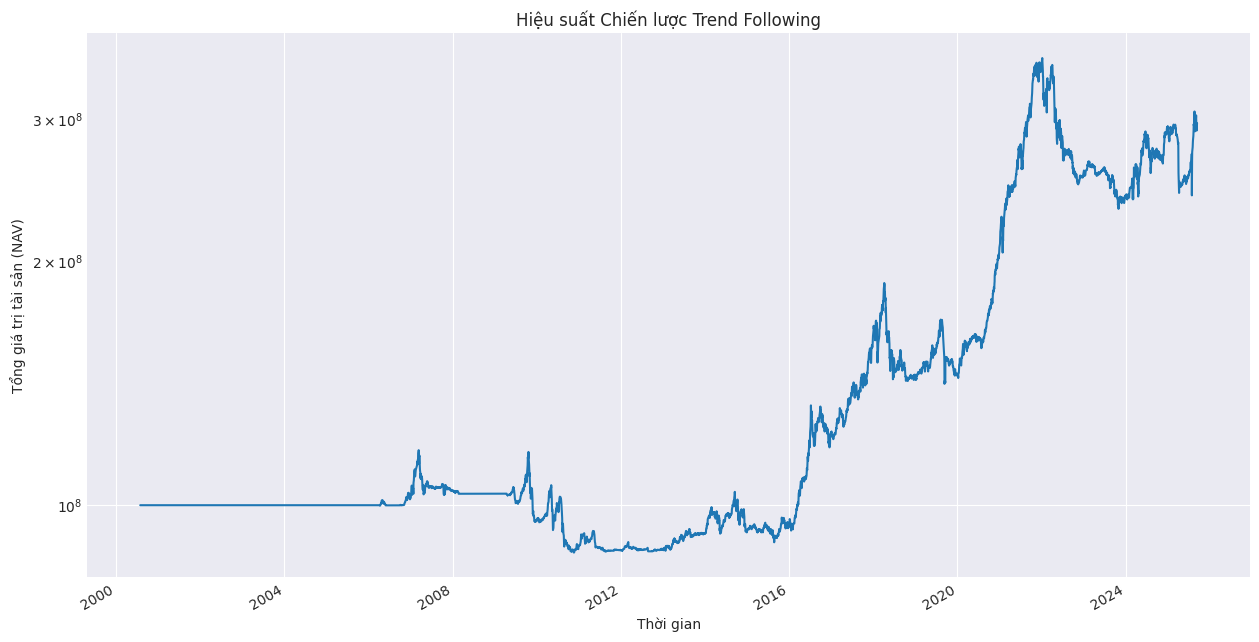

In [17]:
# In và vẽ kết quả
print("\n--- KẾT QUẢ BACKTEST ---")
print(results.tail())

# Tính toán các chỉ số hiệu suất
final_nav = results['nav'].iloc[-1]
initial_nav = config.INITIAL_CAPITAL
years = (results.index.max() - results.index.min()).days / 365.25
cagr = ((final_nav / initial_nav) ** (1 / years)) - 1

print(f"\nVốn ban đầu: {initial_nav:,.0f} VND")
print(f"NAV cuối kỳ:  {final_nav:,.0f} VND")
print(f"Thời gian:    {years:.2f} năm")
print(f"CAGR:         {cagr:.2%}")

# Vẽ biểu đồ NAV
try:
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-darkgrid')
    results['nav'].plot(figsize=(15, 8), title='Hiệu suất Chiến lược Trend Following')
    plt.ylabel('Tổng giá trị tài sản (NAV)')
    plt.xlabel('Thời gian')
    plt.yscale('log') # Dùng thang log để dễ nhìn hơn
    plt.show()
except ImportError:
    print("\nVui lòng cài đặt matplotlib (`pip install matplotlib`) để vẽ biểu đồ.")

### Stock EDA

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Đọc tất cả file csv trong folder
def load_stock_data(folder):
    all_data = []
    for file in tqdm(os.listdir(folder)):
        if file.endswith(".csv"):
            ticker = file.replace(".csv", "")
            df = pd.read_csv(os.path.join(folder, file))
            df["time"] = pd.to_datetime(df["time"])
            df["ticker"] = ticker
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# Thống kê date
def analyze_dates(df):
    stats = df.groupby("ticker").agg(min_date=("time", "min"),
                                     max_date=("time", "max")).reset_index()
    print(stats)

    plt.hist(stats["min_date"], bins=30, alpha=0.7, label="Min dates")
    plt.hist(stats["max_date"], bins=30, alpha=0.7, label="Max dates")
    plt.legend()
    plt.title("Phân phối Min/Max date của các cổ phiếu")
    plt.show()
    return stats

# Thống kê volume
def analyze_volume(df, idx=0):
    vol_stats = df.groupby("ticker")["volume"].mean().sort_values(ascending=False).reset_index()
    print(vol_stats)

    ticker = vol_stats.iloc[idx]["ticker"]
    df_ticker = df[df["ticker"] == ticker]
    
    plt.hist(df_ticker["volume"], bins=50)
    plt.title(f"Phân phối volume của {ticker}")
    plt.show()
    
    return vol_stats

def plot_volume_distribution(vol_stats):
    plt.hist(vol_stats["volume"], bins=50)
    plt.title("Phân phối mean volume của các cổ phiếu")
    plt.yscale("log")
    plt.xlabel("Mean Volume")
    plt.ylabel("Số cổ phiếu")
    plt.show()

# Thống kê giá hiện tại
def analyze_prices(df, n=10000):
    latest_prices = df.sort_values("time").groupby("ticker").tail(1)[["ticker", "close"]]
    print(latest_prices)

    count = (latest_prices["close"] <= n).sum()
    print(f"Số cổ phiếu có giá mới nhất <= {n}: {count}")
    return latest_prices, count

def analyze_nan(df: pd.DataFrame):
    """
    Thống kê NaN cho dữ liệu stock đã load bằng load_stock_data.
    
    Parameters:
        df (pd.DataFrame): DataFrame có cột ['time', 'open', 'high', 'low', 'close', 'volume', 'ticker']
    
    Returns:
        nan_df (pd.DataFrame): số lượng NaN cho từng mã, từng cột
        nan_mean (pd.Series): trung bình số lượng NaN trên mỗi cột
    """

    # Đếm NaN theo từng ticker
    nan_df = df.groupby("ticker").apply(lambda x: x.isna().sum())
    nan_df = nan_df[["time", "open", "high", "low", "close", "volume"]]  # giữ 6 cột chính

    # Tính trung bình NaN theo cột
    nan_mean = nan_df.mean()

    # In kết quả
    print("Số lượng NaN của mỗi mã:")
    print(nan_df)

    print("\nTrung bình số lượng NaN mỗi cột:")
    print(nan_mean)

    # Vẽ phân phối NaN cho từng cột
    for col in nan_df.columns:
        plt.figure(figsize=(6,4))
        plt.hist(nan_df[col], bins=20, edgecolor="black")
        plt.title(f"Phân phối số lượng NaN - cột {col}")
        plt.xlabel("Số NaN")
        plt.ylabel("Số lượng mã")
        plt.show()

    return nan_df, nan_mean


In [19]:
data_folder = "/mnt/c/Users/HOME/Downloads/TF-algo-trading/vci_stock_history"
df_all = load_stock_data(data_folder)
df_all_backup = df_all.copy()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1686/1686 [00:42<00:00, 39.38it/s]


     ticker   min_date   max_date
0       A32 2018-10-23 2025-09-08
1       AAA 2010-07-15 2025-09-12
2       AAH 2024-01-11 2025-09-12
3       AAM 2009-09-24 2025-09-12
4       AAS 2020-07-23 2025-09-12
...     ...        ...        ...
1679    XPH 2014-11-25 2025-09-12
1680    YBC 2008-05-20 2025-09-11
1681    YBM 2018-08-21 2025-09-12
1682    YEG 2018-06-26 2025-09-12
1683    YTC 2017-08-03 2025-09-11

[1684 rows x 3 columns]


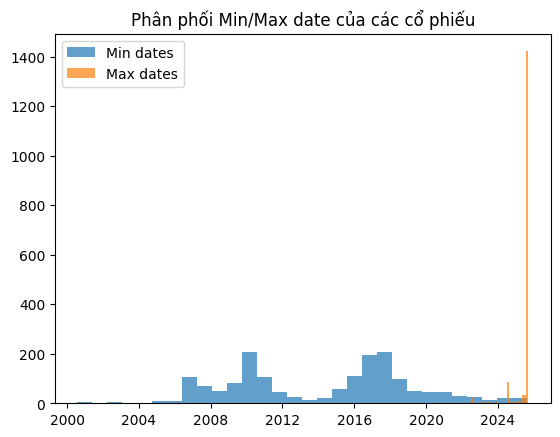

In [18]:
# Thống kê date
stats_date = analyze_dates(df_all)

     ticker        volume
0       VPB  1.177724e+07
1       SHB  1.036628e+07
2       ROS  1.010619e+07
3       HPG  8.964041e+06
4       FLC  8.864954e+06
...     ...           ...
1679    TBW  0.000000e+00
1680    MCD  0.000000e+00
1681    BCO  0.000000e+00
1682    AUM  0.000000e+00
1683    VTM  0.000000e+00

[1684 rows x 2 columns]


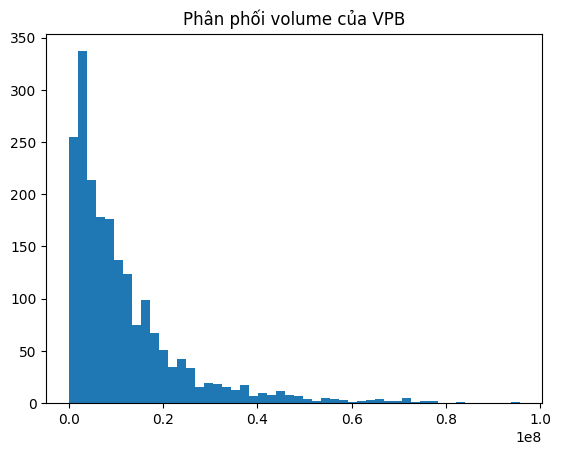

In [44]:
# Thống kê volume, ví dụ chọn idx=0 (cổ phiếu có mean volume cao nhất)
stats_volume = analyze_volume(df_all, idx=0)

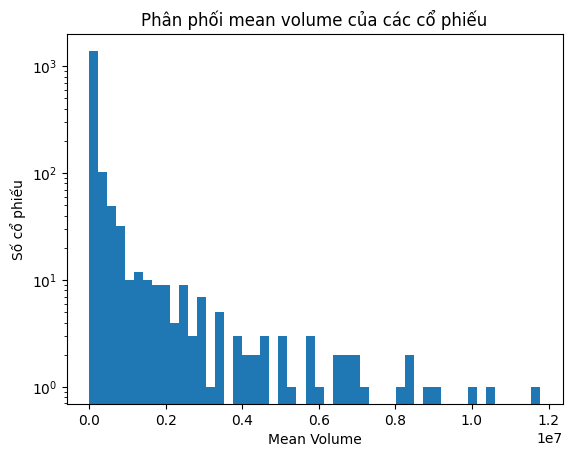

In [37]:
plot_volume_distribution(stats_volume)

In [46]:
# Thống kê giá hiện tại, ví dụ n = 20000
stats_prices, count = analyze_prices(df_all, n=10)

        ticker  close
798336     DAR   13.0
1126284    EAD   28.1
2426267    NS3    8.2
811502     DBH    7.8
1054990    DT4   10.2
...        ...    ...
1567972    HNB   12.5
2581773    PET   30.6
3542872    SWC   31.4
3970028    TVT   15.4
1252541    GCF   35.5

[1684 rows x 2 columns]
Số cổ phiếu có giá mới nhất <= 10: 657


/tmp/ipykernel_149/1251423513.py:75: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nan_df = df.groupby("ticker").apply(lambda x: x.isna().sum())


Số lượng NaN của mỗi mã:
        time  open  high  low  close  volume
ticker                                      
A32        0     0     0    0      0       0
AAA        0     0     0    0      0       0
AAH        0     0     0    0      0       0
AAM        0     0     0    0      0       0
AAS        0     0     0    0      0       0
...      ...   ...   ...  ...    ...     ...
XPH        0     0     0    0      0       0
YBC        0     0     0    0      0       0
YBM        0     0     0    0      0       0
YEG        0     0     0    0      0       0
YTC        0     0     0    0      0       0

[1686 rows x 6 columns]

Trung bình số lượng NaN mỗi cột:
time      0.000000
open      0.013049
high      0.023725
low       0.023725
close     0.025504
volume    0.139976
dtype: float64


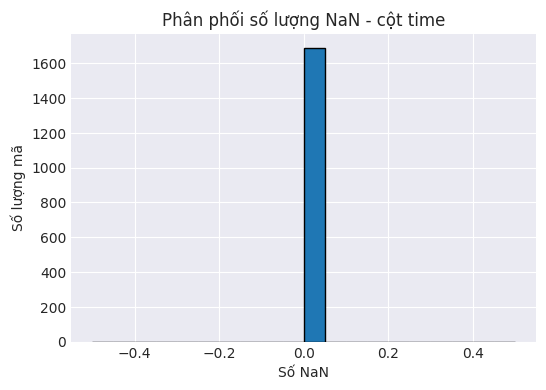

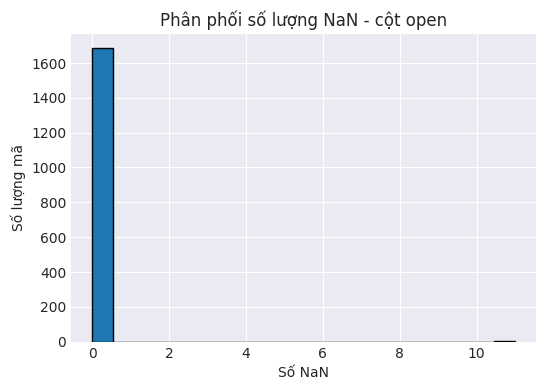

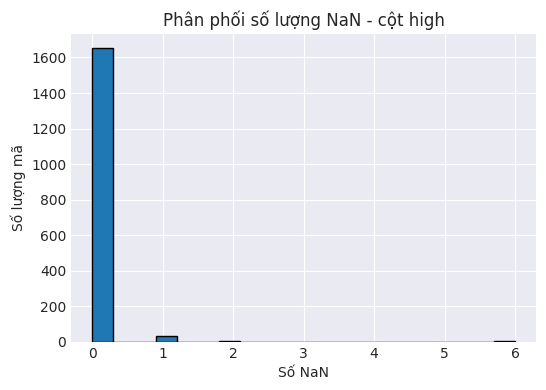

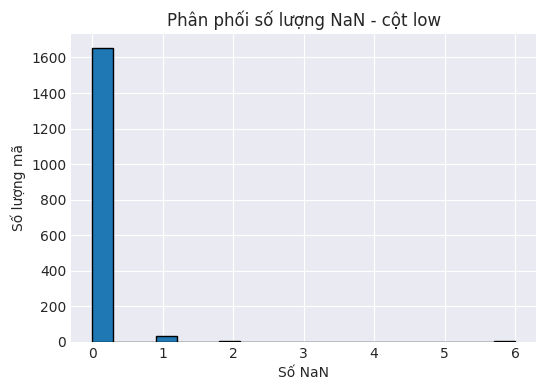

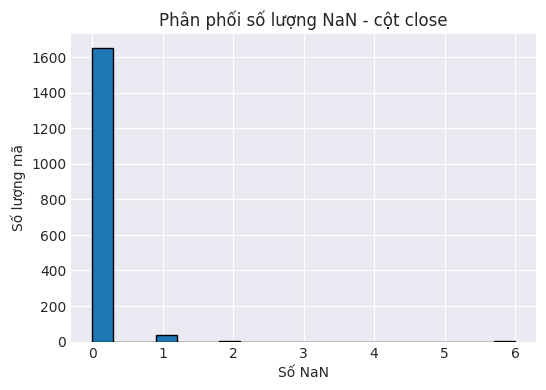

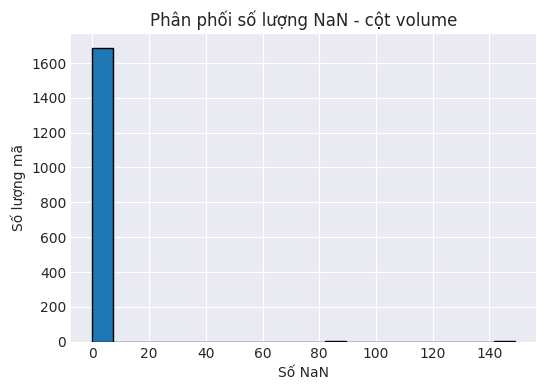

In [20]:
nan_df, nan_mean = analyze_nan(df_all)